In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import pandas as pd
from itertools import cycle
import math
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score, recall_score
import re
import nltk
from nltk.stem import WordNetLemmatizer
import warnings



# Aux Functions

## Ploting

In [3]:
def plot_roc_curves(class_names, fpr, tpr, roc_auc, figsize=(15, 10)):
    distinct_colors = [
        '#9b59b6', '#3498db', '#e74c3c', '#2ecc71',
        '#f39c12', '#1abc9c', '#d35400'
    ]
    
    plt.figure(figsize=figsize)
    
    for i, (class_name, color) in enumerate(zip(class_names, cycle(distinct_colors))):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Toxicity Category')
    plt.legend(loc="lower right", bbox_to_anchor=(1.15, 0))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_pr_curves(class_names, recall, precision, avg_precision, figsize=(15, 10)):
    distinct_colors = [
        '#9b59b6', '#3498db', '#e74c3c', '#2ecc71',
        '#f39c12', '#1abc9c', '#d35400'
    ]
    
    plt.figure(figsize=figsize)
    
    for i, (class_name, color) in enumerate(zip(class_names, cycle(distinct_colors))):
        plt.plot(recall[i], precision[i], color=color, lw=2,
                label=f'{class_name} (AP = {avg_precision[i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for Each Toxicity Category')
    plt.legend(loc="lower left", bbox_to_anchor=(1.15, 0))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [5]:
def plot_metrics_heatmap(metrics_df, figsize=(10, 6)):
    vibrant_purple_palette = ['#4A148C', '#6A1B9A', '#8E24AA', '#AB47BC', '#CE93D8']
    
    plt.figure(figsize=figsize)
    vibrant_cmap = LinearSegmentedColormap.from_list("vibrant_purple", vibrant_purple_palette[::-1])
    
    sns.heatmap(metrics_df, annot=True, cmap=vibrant_cmap, fmt='.3f', 
                cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
    plt.title('Classification Metrics per Toxicity Category', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [6]:
def plot_confusion_matrices(class_names, results, figsize=(15, 10)):
    purple_palette = ['#9b59b6', '#AF7AC5', '#C39BD3', '#D7BDE2', '#E8DAEF']
    dark_purple_palette = ['#6A0DAD', '#8E44AD', '#9B59B6', '#B19CD9', '#D2B4DE']
    
    n_classes = len(class_names)
    n_cols = 3
    n_rows = math.ceil(n_classes / n_cols)
    
    plt.figure(figsize=(15, 4*n_rows))
    
    custom_cmaps = []
    for i in range(len(class_names)):
        if i % 2 == 0:
            custom_cmaps.append(LinearSegmentedColormap.from_list(f"custom_purple_{i}", 
                                                                purple_palette[::-1]))
        else:
            custom_cmaps.append(LinearSegmentedColormap.from_list(f"dark_purple_{i}", 
                                                                dark_purple_palette[::-1]))
    
    for i, class_name in enumerate(class_names):
        cm = np.array([[results['per_class'][class_name]['confusion_matrix']['tn'],
                       results['per_class'][class_name]['confusion_matrix']['fp']],
                      [results['per_class'][class_name]['confusion_matrix']['fn'],
                       results['per_class'][class_name]['confusion_matrix']['tp']]])
        
        row_sums = cm.sum(axis=1)[:, np.newaxis]
        safe_row_sums = np.where(row_sums == 0, 1, row_sums)
        cm_percentage = cm.astype('float') / safe_row_sums * 100
        
        plt.subplot(n_rows, n_cols, i+1)
        sns.heatmap(cm_percentage, annot=True, fmt=',.1f', cmap=custom_cmaps[i],
                    xticklabels=['Non-Toxic', 'Toxic'],
                    yticklabels=['Non-Toxic', 'Toxic'])
        
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'{class_name.replace("_", " ").title()}', fontsize=12, fontweight='bold')
        
        for t in plt.gca().texts:
            t.set_text(t.get_text() + "%")
    
    plt.tight_layout()
    plt.show()

In [7]:
def plot_mean_metrics(results, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'PR AUC']
    values = [
        results['overall']['mean_accuracy'],
        results['overall']['mean_precision'],
        results['overall']['mean_recall'],
        results['overall']['mean_f1_score'],
        results['overall']['mean_roc_auc'],
        results['overall']['mean_average_precision']
    ]
    
    colors = ['#D7BDE2'] * 5 + ['#6A1B9A']
    
    bars = plt.barh(metrics, values, color=colors)
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                 va='center', fontweight='bold')
    
    plt.xlim(0, 1.1)
    plt.title('Mean Performance Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Score', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

In [8]:

def print_classification_report(class_names, results):
    print("\nDetailed Classification Report:")
    print("-" * 50)
    for class_name in class_names:
        print(f"\nCategory: {class_name}")
        print(f"Precision: {results['per_class'][class_name]['precision']:.3f}")
        print(f"Recall: {results['per_class'][class_name]['recall']:.3f}")
        print(f"F1-score: {results['per_class'][class_name]['f1_score']:.3f}")
        print(f"Accuracy: {results['per_class'][class_name]['accuracy']:.3f}")
        print(f"ROC AUC: {results['per_class'][class_name]['roc_auc']:.3f}")
        print(f"Average Precision: {results['per_class'][class_name]['average_precision']:.3f}")
    
    print("\nMean Metrics Across All Toxicity Categories:")
    print("-" * 50)
    for metric, value in results['overall'].items():
        if isinstance(value, dict):
            print(f"{metric}:")
            for sub_metric, sub_value in value.items():
                print(f"  {sub_metric}: {sub_value:.3f}")
        else:
            print(f"{metric}: {value:.3f}")

In [9]:
def compare_models(model1_metrics, model2_metrics, model1_name="Model 1", model2_name="Model 2", figsize=(12, 8)):
    # Extract metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC AUC', 'PR AUC']
    
    model1_values = [
        model1_metrics['overall']['mean_accuracy'],
        model1_metrics['overall']['mean_precision'],
        model1_metrics['overall']['mean_recall'],
        model1_metrics['overall']['mean_f1_score'],
        model1_metrics['overall']['mean_roc_auc'],
        model1_metrics['overall']['mean_average_precision']
    ]
    
    model2_values = [
        model2_metrics['overall']['mean_accuracy'],
        model2_metrics['overall']['mean_precision'],
        model2_metrics['overall']['mean_recall'],
        model2_metrics['overall']['mean_f1_score'],
        model2_metrics['overall']['mean_roc_auc'],
        model2_metrics['overall']['mean_average_precision']
    ]
    
    # Determine which model is better overall (based on average of metrics)
    model1_avg = np.mean(model1_values)
    model2_avg = np.mean(model2_values)
    
    # Set colors based on which model is better
    if model1_avg >= model2_avg:
        model1_colors = ['#8E44AD'] * 5 + ['#4A148C']  # Vibrant purple for most, deep purple for PR AUC
        model2_colors = ['#D7BDE2'] * 5 + ['#9C27B0']  # Light purple for most, medium purple for PR AUC
        better_model = model1_name
    else:
        model1_colors = ['#D7BDE2'] * 5 + ['#9C27B0']  # Light purple for most, medium purple for PR AUC
        model2_colors = ['#8E44AD'] * 5 + ['#4A148C']  # Vibrant purple for most, deep purple for PR AUC
        better_model = model2_name
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Set the positions of the bars
    y_pos = np.arange(len(metrics))
    width = 0.35
    
    # Create horizontal bars
    bars1 = plt.barh(y_pos - width/2, model1_values, width, color=model1_colors, label=model1_name)
    bars2 = plt.barh(y_pos + width/2, model2_values, width, color=model2_colors, label=model2_name)
    
    # Add value annotations beside each bar
    for bars in [bars1, bars2]:
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.3f}', 
                     va='center')
    
    # Customize the plot
    plt.yticks(y_pos, metrics)
    plt.xlim(0, 1.1)
    plt.title(f'Model Comparison: {model1_name} vs {model2_name}\n(Better Overall: {better_model})', 
              fontsize=16)
    plt.xlabel('Score', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(axis='x', alpha=0.3)
    
    # Add a subtle highlight to the PR AUC row
    plt.axhspan(y_pos[-1] - width/2 - 0.1, y_pos[-1] + width/2 + width - 0.2, alpha=0.2, color='purple')
    
    
    plt.tight_layout()
    plt.show()
    
    # Print the numeric comparison
    print(f"\nNumeric Comparison ({model1_name} vs {model2_name}):")
    print("-" * 50)
    
    # Compare overall metrics
    print("\nOverall Metrics:")
    for i, metric in enumerate(metrics):
        diff = model1_values[i] - model2_values[i]
        better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
        print(f"{metric:12}: {model1_values[i]:.3f} vs {model2_values[i]:.3f} "
              f"(Diff: {abs(diff):.3f}, Better: {better})")
    
    # Compare per-class metrics
    print("\nPer-Class Metrics:")
    for class_name in model1_metrics['per_class'].keys():
        print(f"\n{class_name}:")
        class_metrics = ['precision', 'recall', 'f1_score', 'accuracy', 'roc_auc', 'average_precision']
        for metric in class_metrics:
            m1_value = model1_metrics['per_class'][class_name][metric]
            m2_value = model2_metrics['per_class'][class_name][metric]
            diff = m1_value - m2_value
            better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
            print(f"{metric:12}: {m1_value:.3f} vs {m2_value:.3f} "
                  f"(Diff: {abs(diff):.3f}, Better: {better})")
    
    print(f"\nOverall Average: {model1_name}: {model1_avg:.3f}, {model2_name}: {model2_avg:.3f}")
    print(f"Better Model Overall: {better_model} by {abs(model1_avg - model2_avg):.3f} points")
    
    # Compare weighted averages
    print("\nWeighted Averages:")
    for metric in ['precision', 'recall', 'f1_score']:
        m1_value = model1_metrics['overall']['weighted_avg'][metric]
        m2_value = model2_metrics['overall']['weighted_avg'][metric]
        diff = m1_value - m2_value
        better = model1_name if diff > 0 else model2_name if diff < 0 else "Tie"
        print(f"{metric:12}: {m1_value:.3f} vs {m2_value:.3f} "
              f"(Diff: {abs(diff):.3f}, Better: {better})")


## Metrics

In [10]:
def evaluate_model(model, test_set, threshold=0.5, plot=True):
    X_test, y_test = test_set
    
    if hasattr(y_test, 'values'):
        y_test = y_test.values
    
    y_pred_proba = model.predict_proba(X_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    toxicity_categories = [
        'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
        'identity_attack', 'insult', 'threat'
    ]
    
    class_names = toxicity_categories[:y_test.shape[1]]
    
    results = {
        'per_class': {},
        'overall': {}
    }
    
    # Calculate curve metrics for plotting
    fpr, tpr, precision, recall = {}, {}, {}, {}
    roc_auc, avg_precision = {}, {}
    
    for i, class_name in enumerate(class_names):
        # ROC curve metrics
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Precision-Recall curve metrics
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_proba[:, i])
        avg_precision[i] = average_precision_score(y_test[:, i], y_pred_proba[:, i])
        
        # Classification report
        report = classification_report(y_test[:, i], y_pred[:, i], output_dict=True, zero_division=0)
        
        # Confusion matrix
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        
        results['per_class'][class_name] = {
            'roc_auc': roc_auc[i],
            'average_precision': avg_precision[i],
            'precision': report['1']['precision'],
            'recall': report['1']['recall'],
            'f1_score': report['1']['f1-score'],
            'accuracy': report['accuracy'],
            'confusion_matrix': {
                'tn': cm[0][0],
                'fp': cm[0][1],
                'fn': cm[1][0],
                'tp': cm[1][1]
            },
            'support': {
                'negative': report['0']['support'],
                'positive': report['1']['support']
            }
        }
    
    # Calculate overall metrics
    all_metrics = pd.DataFrame([results['per_class'][cn] for cn in class_names])
    
    results['overall'] = {
        'mean_roc_auc': all_metrics['roc_auc'].mean(),
        'mean_average_precision': all_metrics['average_precision'].mean(),
        'mean_precision': all_metrics['precision'].mean(),
        'mean_recall': all_metrics['recall'].mean(),
        'mean_f1_score': all_metrics['f1_score'].mean(),
        'mean_accuracy': all_metrics['accuracy'].mean(),
        'macro_avg': {
            'precision': np.mean([results['per_class'][cn]['precision'] for cn in class_names]),
            'recall': np.mean([results['per_class'][cn]['recall'] for cn in class_names]),
            'f1_score': np.mean([results['per_class'][cn]['f1_score'] for cn in class_names])
        },
        'weighted_avg': {
            'precision': np.average([results['per_class'][cn]['precision'] for cn in class_names],
                                  weights=[results['per_class'][cn]['support']['positive'] for cn in class_names]),
            'recall': np.average([results['per_class'][cn]['recall'] for cn in class_names],
                               weights=[results['per_class'][cn]['support']['positive'] for cn in class_names]),
            'f1_score': np.average([results['per_class'][cn]['f1_score'] for cn in class_names],
                                 weights=[results['per_class'][cn]['support']['positive'] for cn in class_names])
        },
        'total_support': {
            'negative': sum(results['per_class'][cn]['support']['negative'] for cn in class_names),
            'positive': sum(results['per_class'][cn]['support']['positive'] for cn in class_names)
        }
    }
    
    if plot:
        # Create metrics DataFrame for visualization
        metrics_df = pd.DataFrame({cn: {
            'Precision': results['per_class'][cn]['precision'],
            'Recall': results['per_class'][cn]['recall'],
            'F1-score': results['per_class'][cn]['f1_score'],
            'AP': results['per_class'][cn]['average_precision']
        } for cn in class_names}).T
        
        # Generate all plots
        plot_roc_curves(class_names, fpr, tpr, roc_auc)
        plot_pr_curves(class_names, recall, precision, avg_precision)
        plot_metrics_heatmap(metrics_df)
        plot_confusion_matrices(class_names, results)
        plot_mean_metrics(results)
        print_classification_report(class_names, results)
    
    return results

In [11]:
# Calculate mean area under precision-recall curve across all labels.
def pr_auc_score(y_true, y_pred):
    pr_aucs = []
    
    for i in range(y_true.shape[1]):
        try:
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
            pr_auc = auc(recall, precision)
            pr_aucs.append(pr_auc)
        except Exception as e:
            warnings.warn(f"Error calculating PR AUC for label {i}: {e}")
            pr_aucs.append(0.0)  # Default to 0 on error
    
    if not pr_aucs:
        return 0.0
    
    return np.mean(pr_aucs)

## Others

In [ ]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)``
    return ' '.join([lemmatizer.lemmatize(token) for token in tokens])

In [13]:
def optimize_multilabel_classifier(
    X_train, y_train, X_test, y_test, toxic_categories,
    use_random_search=False,
    n_iter=10,
    cv=3,
    n_jobs=1,
    verbose=1,
    visualize=True,
    reduced_params=True
):
    
    # Define parameter grid based on reduced_params flag
    if reduced_params:
        # Smaller parameter grid
        param_grid = {
            'estimator__C': [0.1, 1.0, 10.0],
            'estimator__penalty': ['l2'],  # Only l2 penalty
            'estimator__class_weight': [None, 'balanced'],
            'estimator__solver': ['liblinear'],
            'estimator__max_iter': [1000]
        }
    else:
        # Full parameter grid
        param_grid = {
            'estimator__C': [0.01, 0.1, 1.0, 10.0, 100.0],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__class_weight': [None, 'balanced'],
            'estimator__solver': ['liblinear'],
            'estimator__max_iter': [1000]
        }
    
    # Initialize base classifier
    base_classifier = LogisticRegression(random_state=42)
    
    # Create OneVsRestClassifier
    multilabel_classifier = OneVsRestClassifier(base_classifier)
    
    # Create a custom scorer class that implements the __call__ method
    class MultilabelPRAUCScorer:
        def __call__(self, estimator, X, y):
            y_pred_proba = estimator.predict_proba(X)
            return pr_auc_score(y, y_pred_proba)
    
    # Choose search method based on parameter
    try:
        if use_random_search:
            print("Using RandomizedSearchCV...")
            search = RandomizedSearchCV(
                estimator=multilabel_classifier,
                param_distributions=param_grid,
                n_iter=n_iter,
                scoring=MultilabelPRAUCScorer(),  # Use the custom scorer class directly
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                random_state=42,
                return_train_score=True,
                error_score='raise'
            )
        else:
            print("Using GridSearchCV...")
            search = GridSearchCV(
                estimator=multilabel_classifier,
                param_grid=param_grid,
                scoring=MultilabelPRAUCScorer(),  # Use the custom scorer class directly
                cv=cv,
                n_jobs=n_jobs,
                verbose=verbose,
                return_train_score=True,
                error_score='raise'
            )
        
        # Convert target values to binary (0 or 1) based on threshold
        y_train_binary = (y_train >= 0.5).astype(int)
        
        # Fit the search
        print("Starting parameter search...")
        search.fit(X_train, y_train_binary)
        print("Parameter search complete!")
        
        # Print best parameters and score
        print(f"Best parameters: {search.best_params_}")
        print(f"Best mean PR AUC score: {search.best_score_:.4f}")
        
        # Get the best model
        best_model = search.best_estimator_
        best_params = search.best_params_
        
    except Exception as e:
        print(f"Error during parameter search: {e}")
        print("Falling back to default model...")
        
        # Create a default model as fallback
        base_classifier = LogisticRegression(
            C=1.0,
            penalty='l2',
            class_weight='balanced',
            solver='liblinear',
            max_iter=1000,
            random_state=42
        )
        best_model = OneVsRestClassifier(base_classifier)
        
        # Train the fallback model
        y_train_binary = (y_train >= 0.5).astype(int)
        best_model.fit(X_train, y_train_binary)
        
        # Return default parameters
        best_params = {
            'estimator__C': 1.0,
            'estimator__penalty': 'l2',
            'estimator__class_weight': 'balanced',
            'estimator__solver': 'liblinear',
            'estimator__max_iter': 1000
        }
    
    # Evaluate on test set
    y_test_binary = (y_test >= 0.5).astype(int)
    y_pred_proba = best_model.predict_proba(X_test)
    
    # Calculate PR AUC for each label
    print("\nPrecision-Recall AUC for each label:")
    label_pr_aucs = {}
    mean_pr_auc_value = 0
    
    for i, label in enumerate(toxic_categories):
        try:
            precision, recall, _ = precision_recall_curve(y_test_binary[:, i], y_pred_proba[:, i])
            pr_auc_value = auc(recall, precision)
            label_pr_aucs[label] = pr_auc_value
            mean_pr_auc_value += pr_auc_value
            print(f"{label}: {pr_auc_value:.4f}")
        except Exception as e:
            print(f"Error calculating PR AUC for {label}: {e}")
            label_pr_aucs[label] = 0.0
    
    # Calculate mean PR AUC
    mean_pr_auc_value /= len(toxic_categories)
    print(f"\nMean Precision-Recall AUC across all labels: {mean_pr_auc_value:.4f}")
    
    return best_model, best_params, mean_pr_auc_value

# Baseline with Raw Data

> Baseline model: Logistic Regression with Raw Dataset

In [57]:
# Load the dataset
df = pd.read_csv("../../data/all_data.csv")

# Basic cleaning
df['comment_text'] = df['comment_text'].fillna('')

# Define toxic categories (target variables)
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
                   'identity_attack', 'insult', 'threat']

print(f"Data loaded with shape: {df.shape}")
print(f"Target categories: {toxic_categories}")

# Create feature matrix (X) and target matrix (y)
X_train = df['comment_text']  # Using the raw text as features
y_train = df[toxic_categories].values  # Multi-label target matrix

test_df = pd.read_csv("../../data/merged_data/test_merged.csv")

X_test = test_df['comment_text']
y_test = test_df[toxic_categories].values

Data loaded with shape: (1999516, 46)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_5360/504826677.py:18: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("../../data/merged_data/test_merged.csv")


In [58]:
X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

> Feature Extraction with TF IDF

In [59]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=40000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")


Training set shape: (1999516, 40000)
Testing set shape: (258619, 40000)
Target shape: (1999516, 7)


In [60]:
best_model, best_params, mean_pr_auc = optimize_multilabel_classifier(
    X_train_tfidf, y_train, X_test_tfidf, y_test, toxic_categories,
    use_random_search=True, n_iter=10, n_jobs=1, reduced_params=False
)

Using RandomizedSearchCV...
Starting parameter search...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-pack

Parameter search complete!
Best parameters: {'estimator__solver': 'liblinear', 'estimator__penalty': 'l1', 'estimator__max_iter': 1000, 'estimator__class_weight': None, 'estimator__C': 1.0}
Best mean PR AUC score: 0.3518

Precision-Recall AUC for each label:
toxicity: 0.6780
severe_toxicity: 0.0138
obscene: 0.5940
sexual_explicit: 0.0729
identity_attack: 0.2985
insult: 0.6335
threat: 0.2776

Mean Precision-Recall AUC across all labels: 0.3669


> Model Evaluation

Evaluating the model...


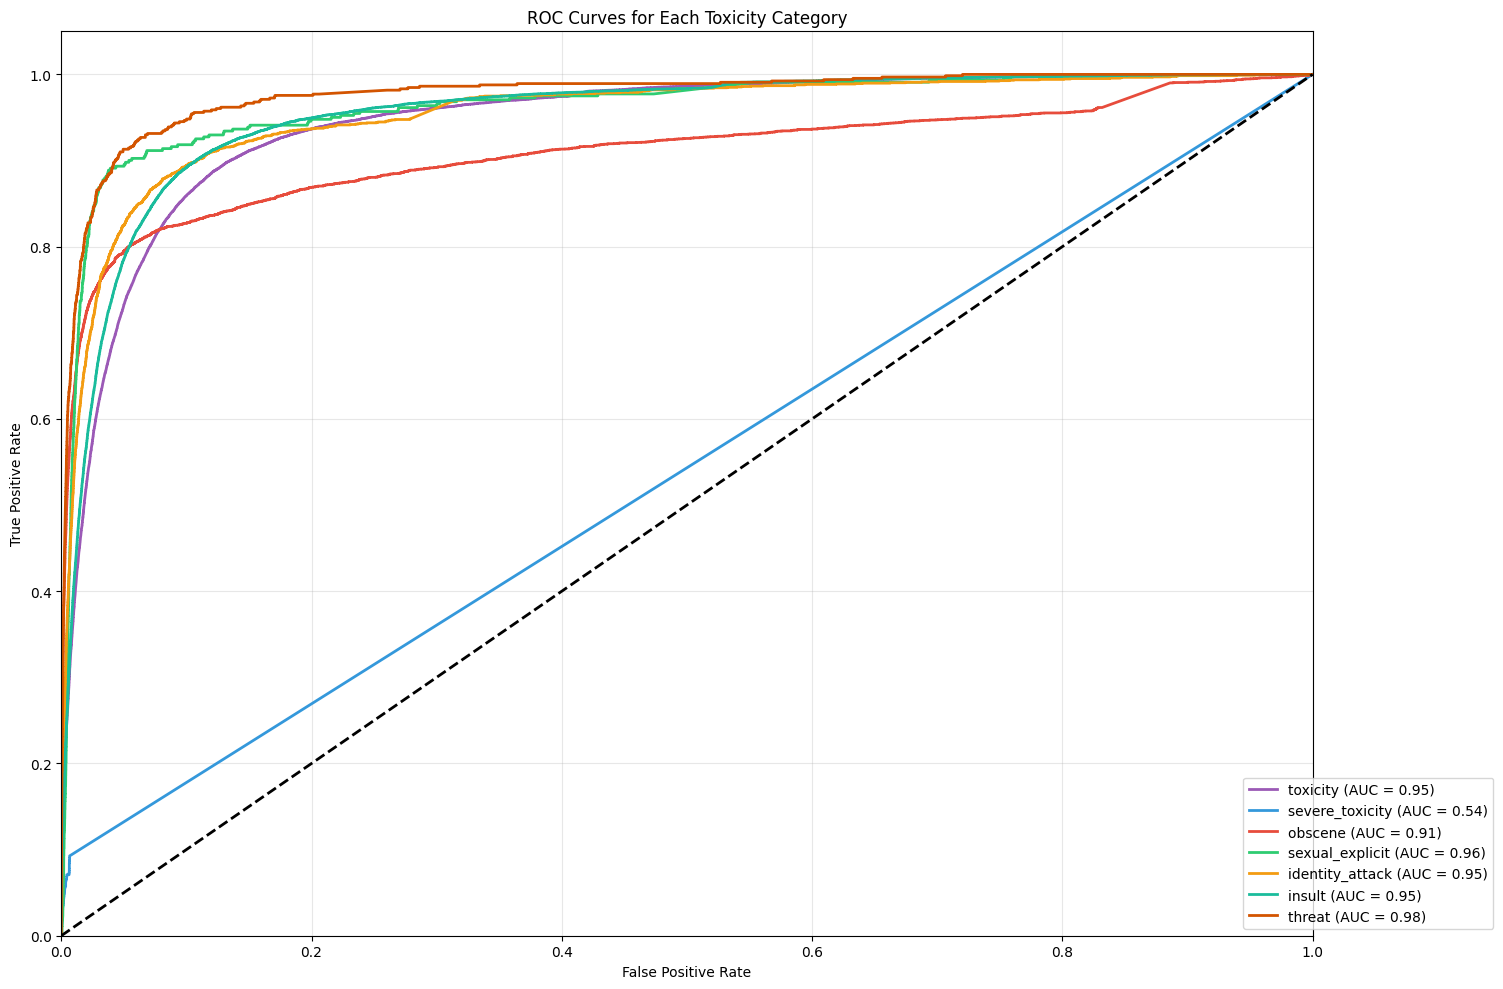

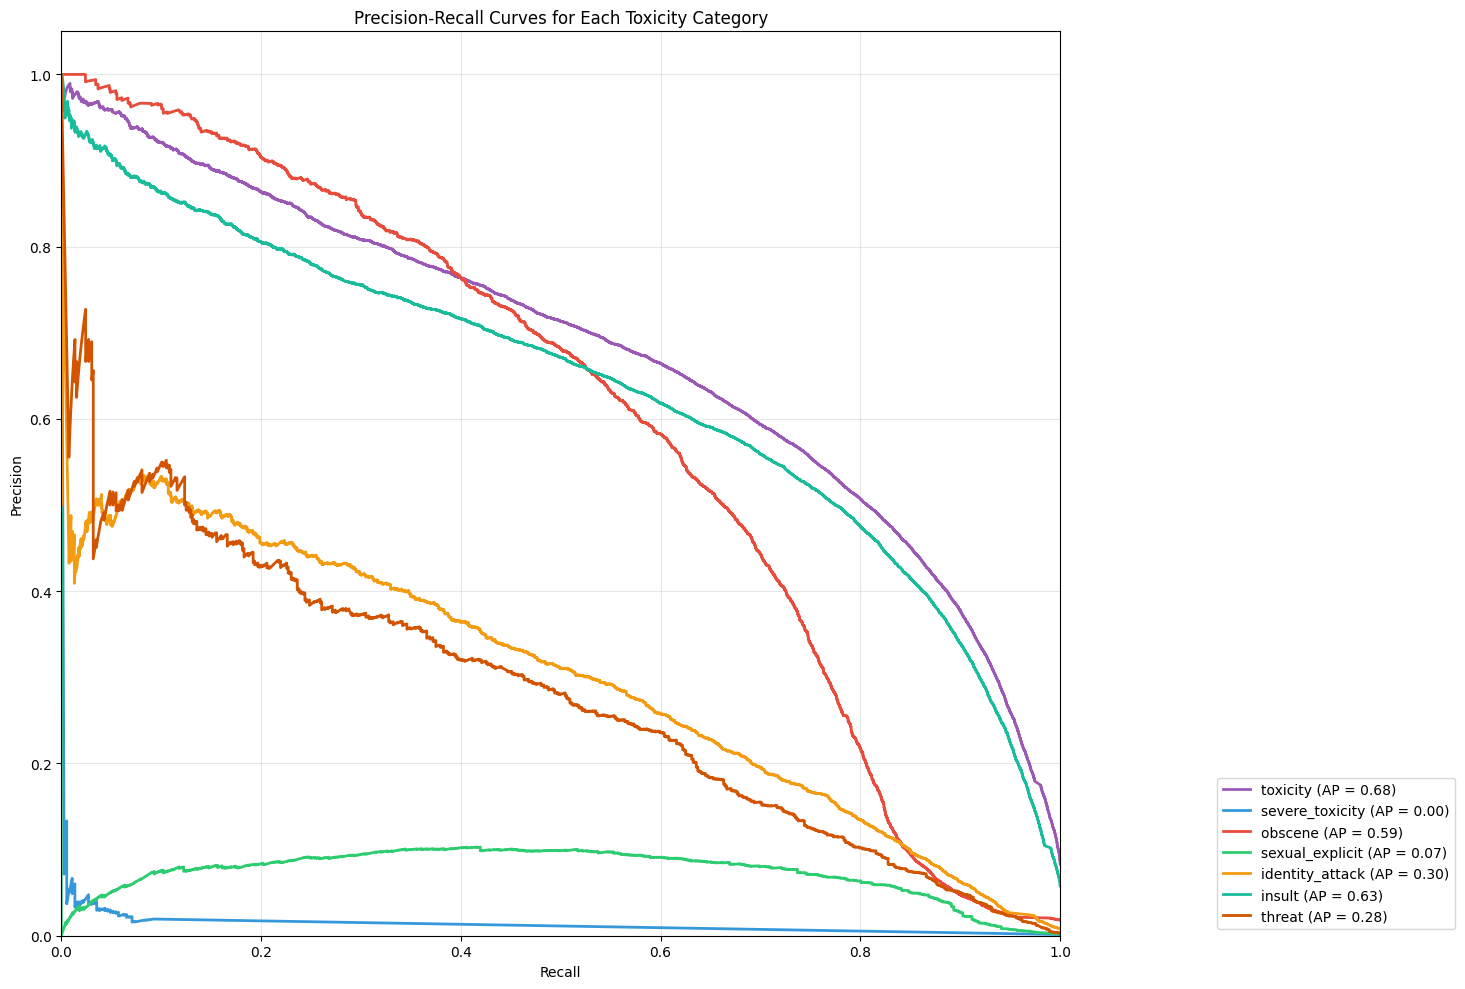

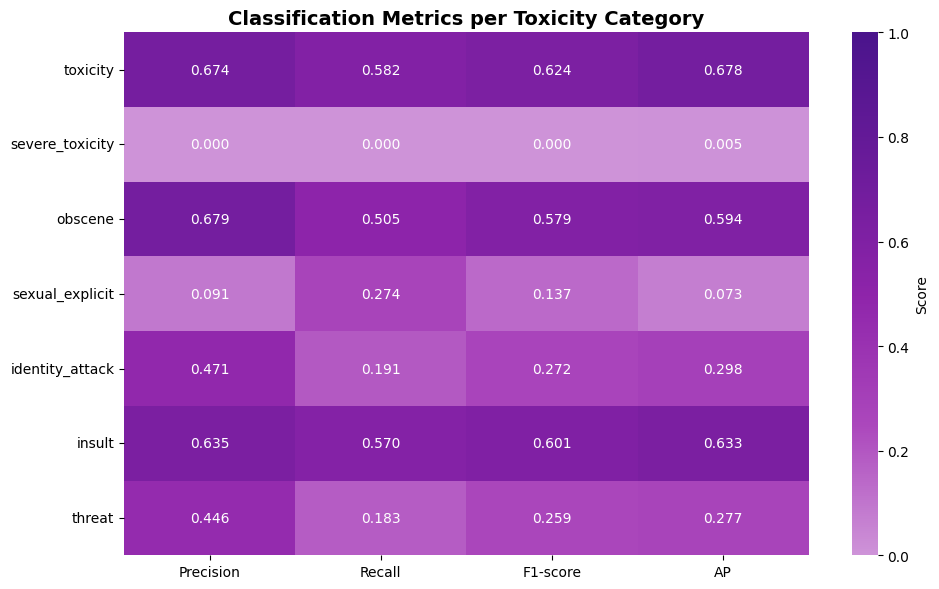

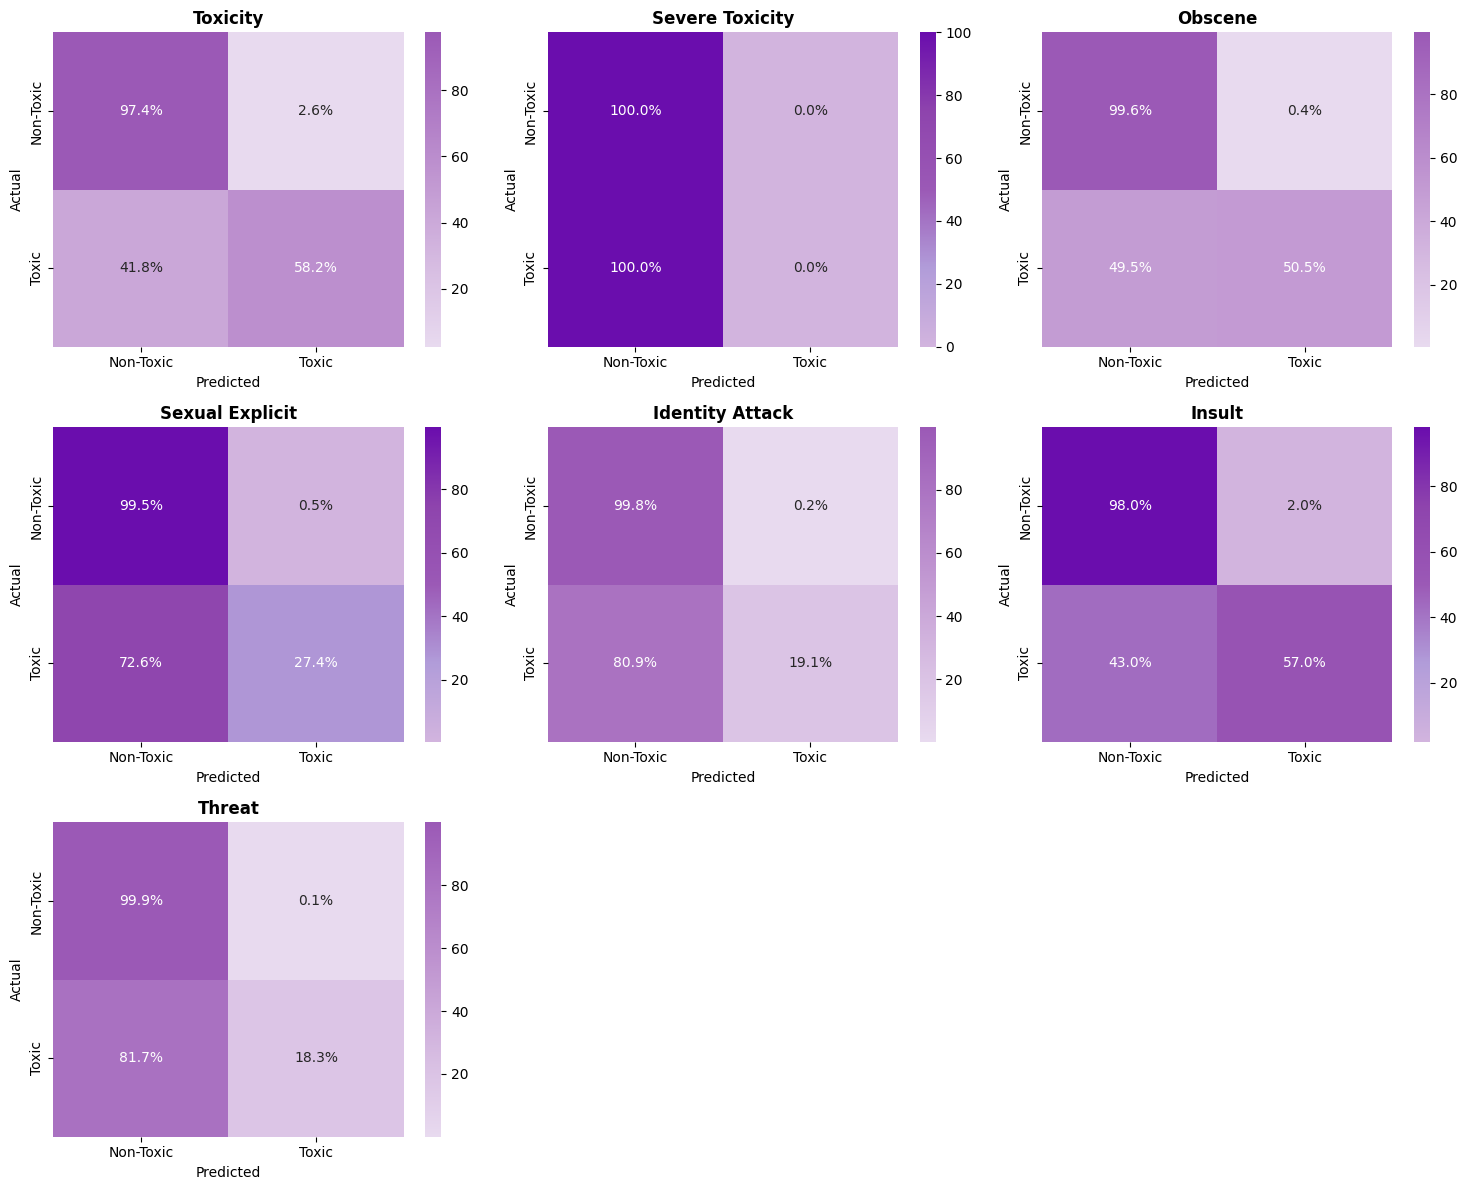

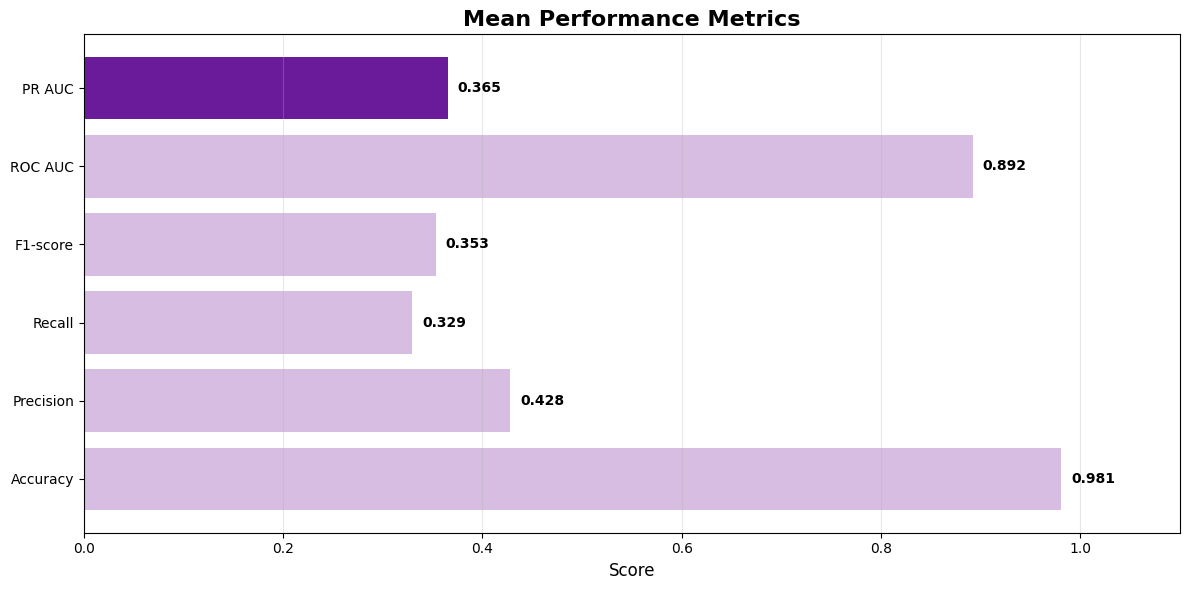


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.674
Recall: 0.582
F1-score: 0.624
Accuracy: 0.942
ROC AUC: 0.945
Average Precision: 0.678

Category: severe_toxicity
Precision: 0.000
Recall: 0.000
F1-score: 0.000
Accuracy: 0.999
ROC AUC: 0.543
Average Precision: 0.005

Category: obscene
Precision: 0.679
Recall: 0.505
F1-score: 0.579
Accuracy: 0.986
ROC AUC: 0.910
Average Precision: 0.594

Category: sexual_explicit
Precision: 0.091
Recall: 0.274
F1-score: 0.137
Accuracy: 0.994
ROC AUC: 0.963
Average Precision: 0.073

Category: identity_attack
Precision: 0.471
Recall: 0.191
F1-score: 0.272
Accuracy: 0.992
ROC AUC: 0.954
Average Precision: 0.298

Category: insult
Precision: 0.635
Recall: 0.570
F1-score: 0.601
Accuracy: 0.956
ROC AUC: 0.953
Average Precision: 0.633

Category: threat
Precision: 0.446
Recall: 0.183
F1-score: 0.259
Accuracy: 0.997
ROC AUC: 0.977
Average Precision: 0.277

Mean Metrics Across All Toxicity Categ

In [61]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)
y_train_binary = (y_train >= 0.5).astype(int)

base_classifier = LogisticRegression(solver= 'liblinear', penalty='l1', max_iter= 1000, class_weight= None, C= 1.0)
best_model = OneVsRestClassifier(base_classifier)
best_model.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_raw_data = evaluate_model(model=best_model, test_set=test_set)

# Baseline with Undersampled Dataset

> Baseline Model: Logistic Regression with Undersampling and Data from the Wikipedia dataset -> Merged Dataset + Undersampling

In [54]:
# Load the dataset
df = pd.read_csv("../../data/merged_data/undersampled_dataset.csv")

# Basic cleaning
df['comment_text'] = df['comment_text'].fillna('')

# Define toxic categories (target variables)
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
                   'identity_attack', 'insult', 'threat']

print(f"Data loaded with shape: {df.shape}")
print(f"Target categories: {toxic_categories}")

# Create feature matrix (X) and target matrix (y)
X_train = df['comment_text']  # Using the raw text as features
y_train = df[toxic_categories].values  # Multi-label target matrix

test_df = pd.read_csv('../../data/merged_data/test_merged.csv')

X_test = test_df['comment_text']
y_test = test_df[toxic_categories].values

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)

Data loaded with shape: (457983, 34)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_5360/4095953715.py:18: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('../../data/merged_data/test_merged.csv')


> Feature Extraction with TF IDF

In [55]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")


Training set shape: (457983, 20000)
Testing set shape: (258619, 20000)
Target shape: (457983, 7)


Evaluating the model...


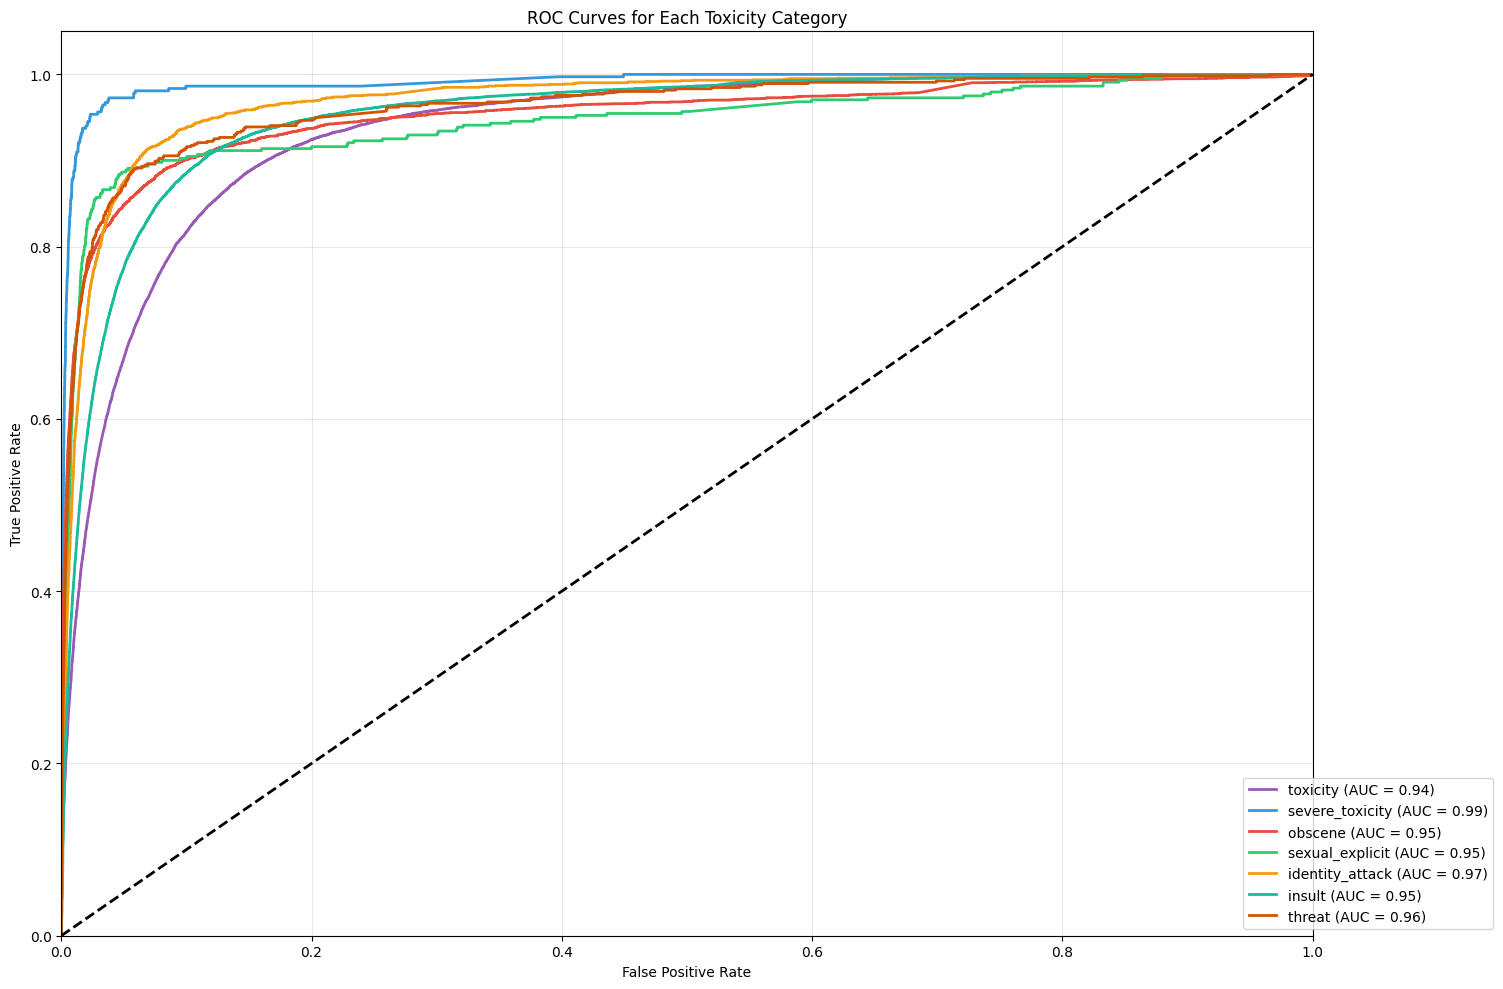

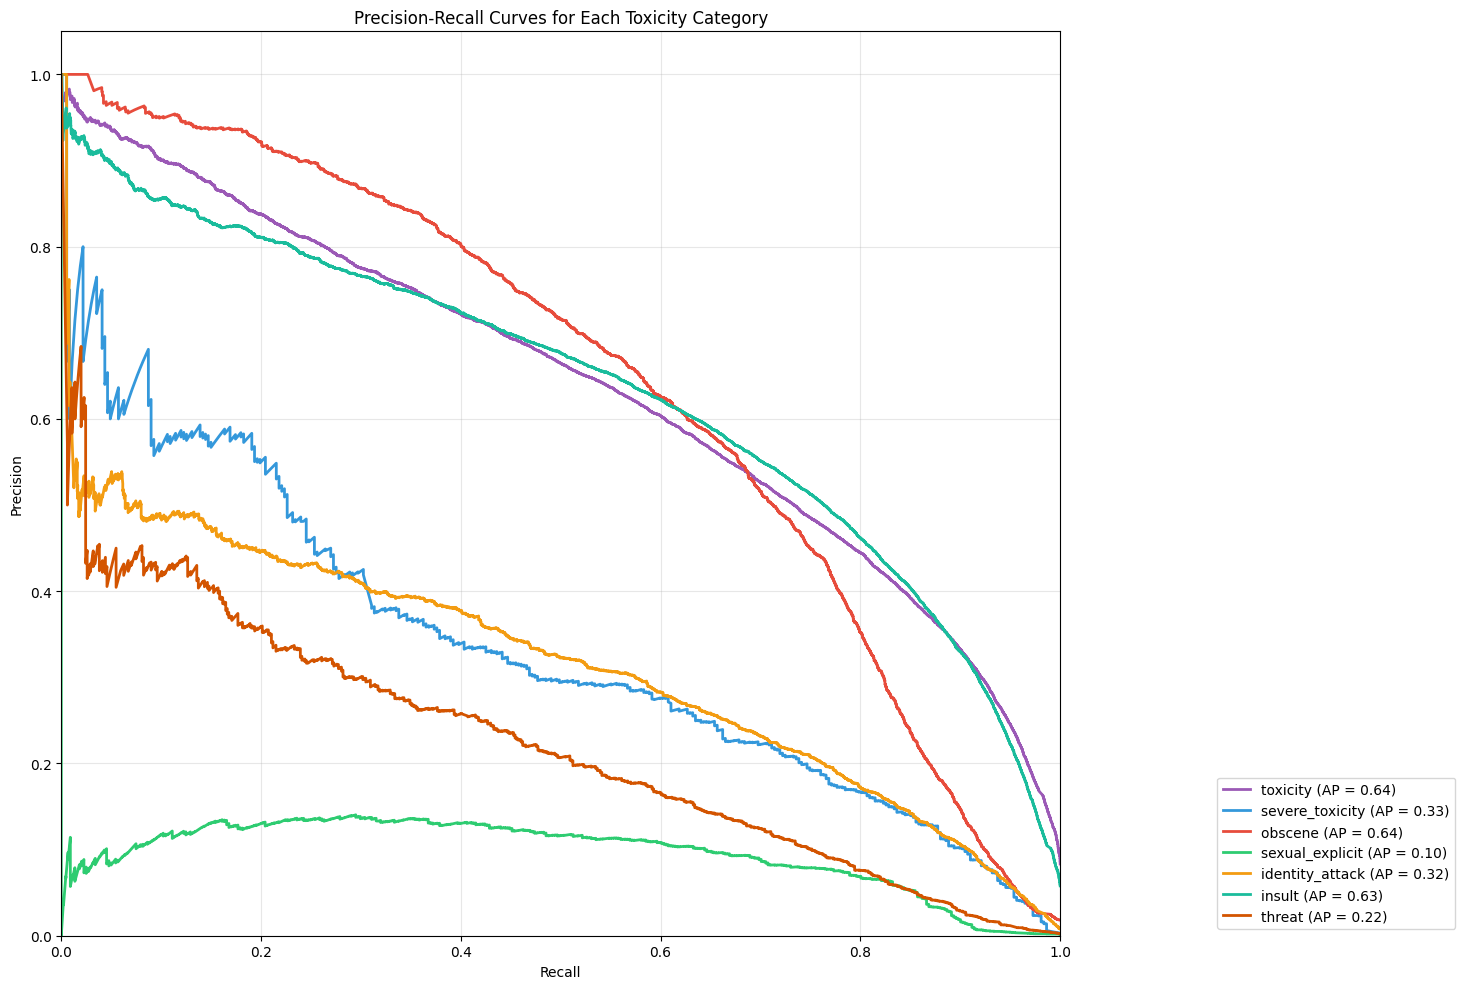

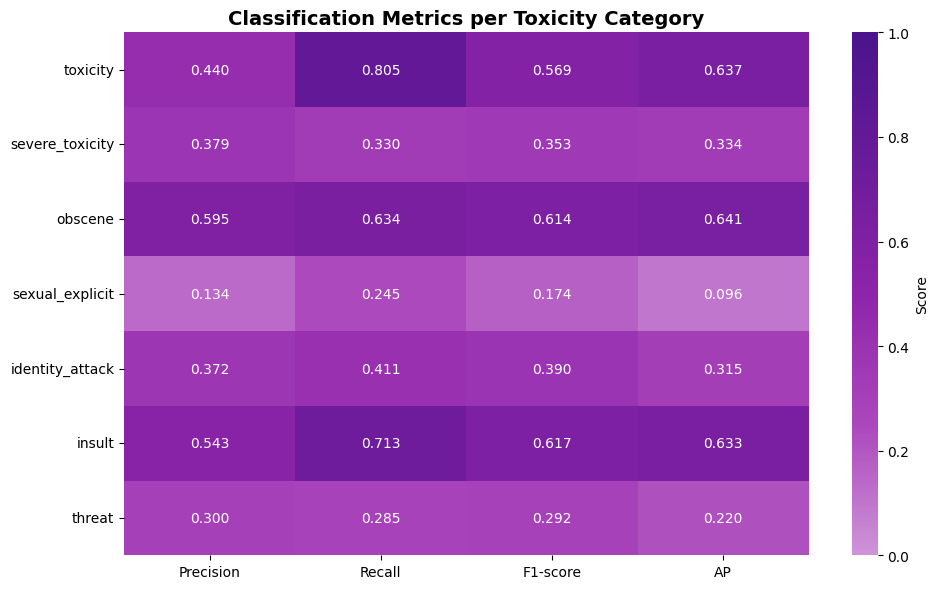

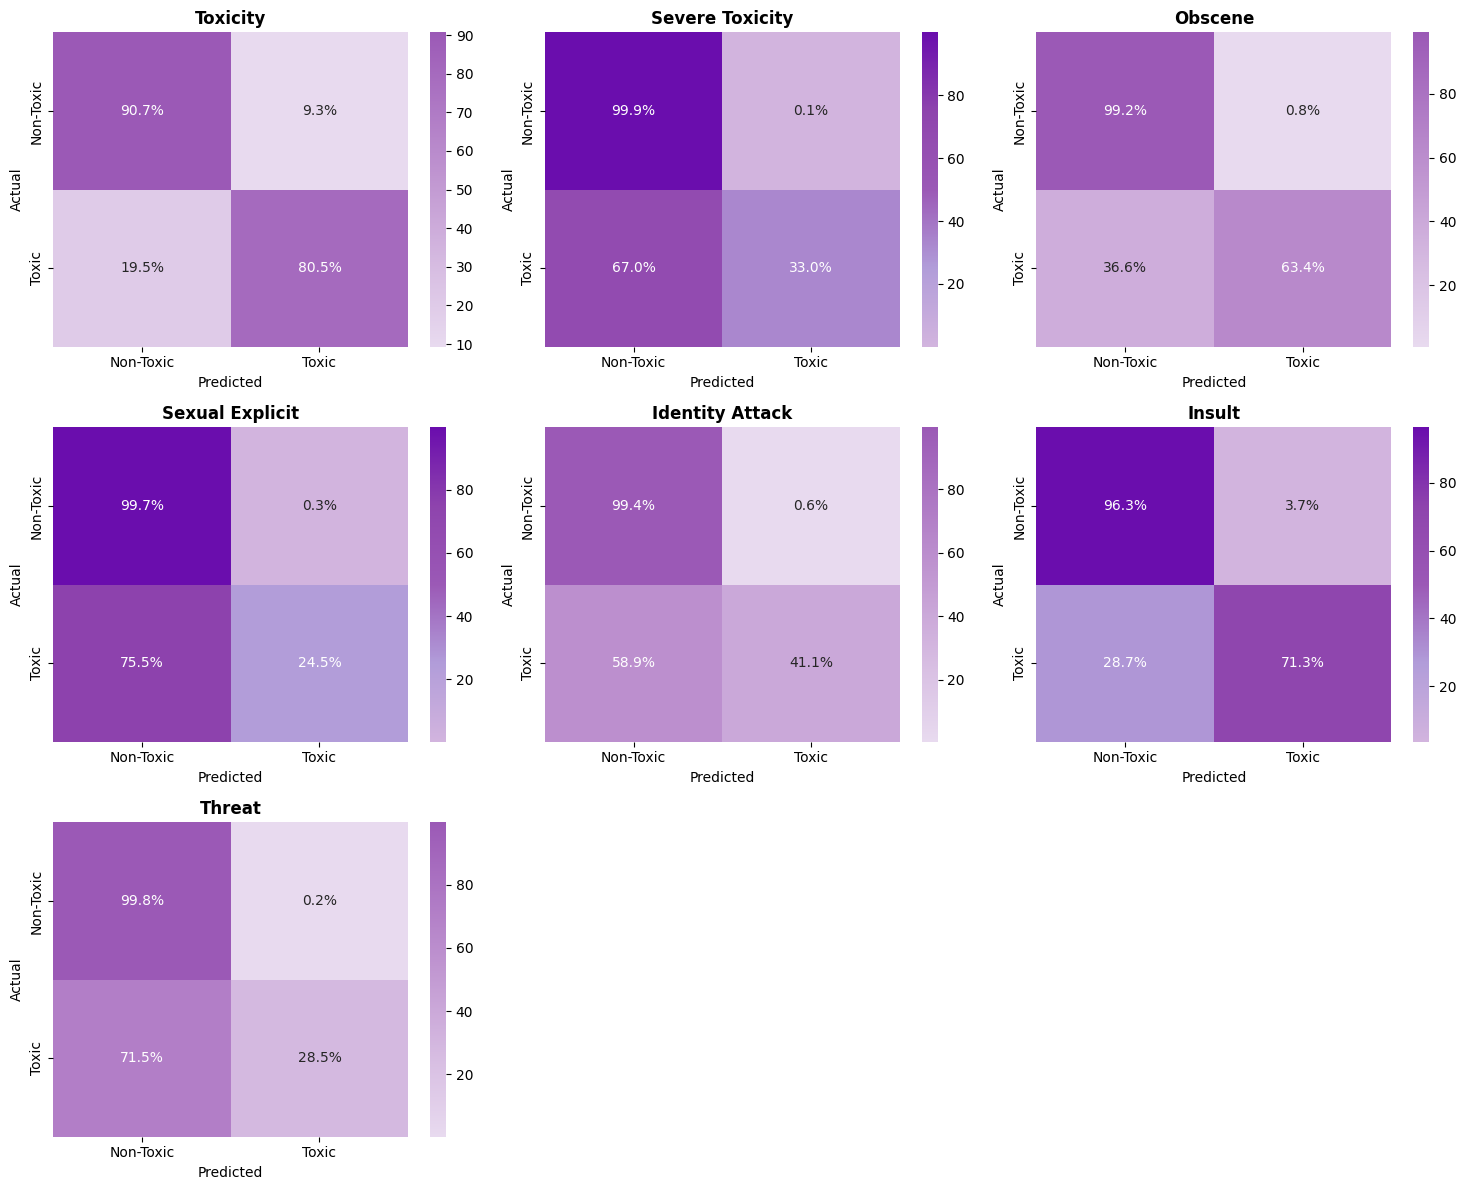

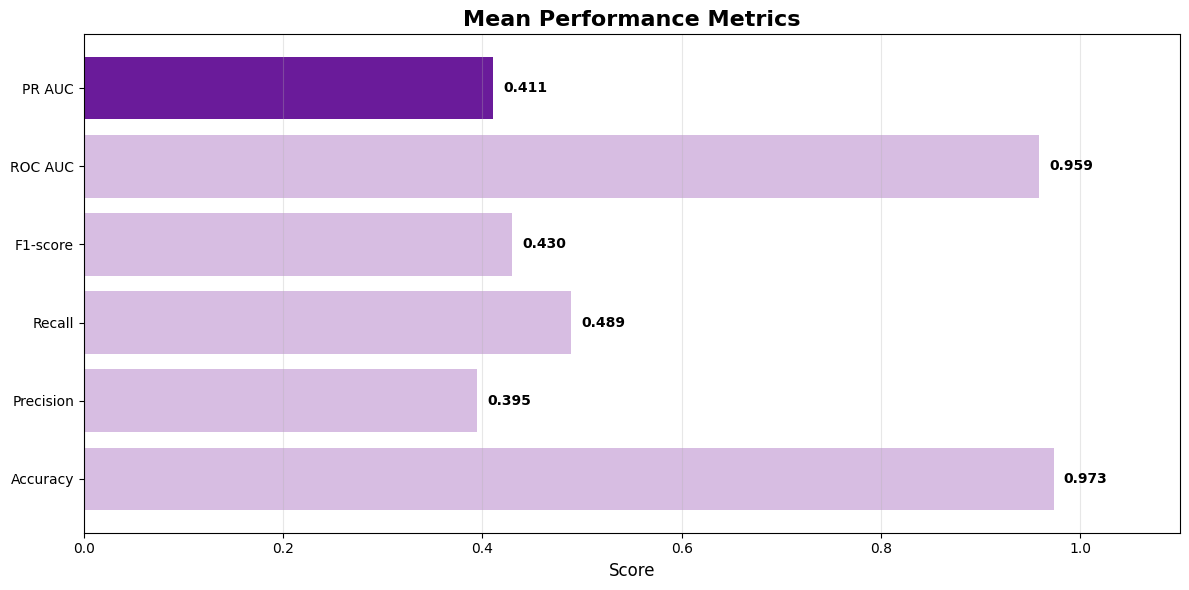


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.440
Recall: 0.805
F1-score: 0.569
Accuracy: 0.898
ROC AUC: 0.937
Average Precision: 0.637

Category: severe_toxicity
Precision: 0.379
Recall: 0.330
F1-score: 0.353
Accuracy: 0.998
ROC AUC: 0.991
Average Precision: 0.334

Category: obscene
Precision: 0.595
Recall: 0.634
F1-score: 0.614
Accuracy: 0.985
ROC AUC: 0.953
Average Precision: 0.641

Category: sexual_explicit
Precision: 0.134
Recall: 0.245
F1-score: 0.174
Accuracy: 0.996
ROC AUC: 0.946
Average Precision: 0.096

Category: identity_attack
Precision: 0.372
Recall: 0.411
F1-score: 0.390
Accuracy: 0.990
ROC AUC: 0.970
Average Precision: 0.315

Category: insult
Precision: 0.543
Recall: 0.713
F1-score: 0.617
Accuracy: 0.949
ROC AUC: 0.953
Average Precision: 0.633

Category: threat
Precision: 0.300
Recall: 0.285
F1-score: 0.292
Accuracy: 0.996
ROC AUC: 0.963
Average Precision: 0.220

Mean Metrics Across All Toxicity Categ

In [56]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

# Wrap in OneVsRestClassifier for multi-label classification
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_undersampling = evaluate_model(model=multilabel_classifier, test_set=test_set)


> Comparing with the Baseline using Raw Data

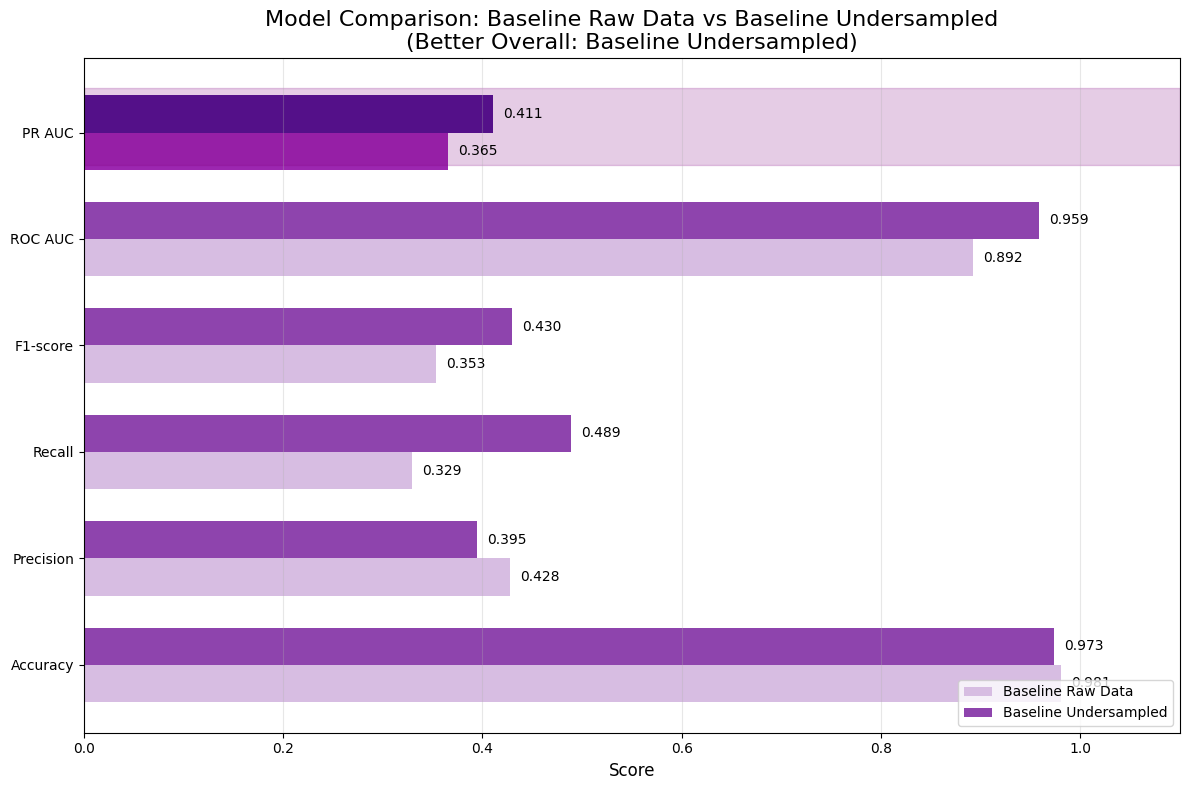


Numeric Comparison (Baseline Raw Data vs Baseline Undersampled):
--------------------------------------------------

Overall Metrics:
Accuracy    : 0.981 vs 0.973 (Diff: 0.008, Better: Baseline Raw Data)
Precision   : 0.428 vs 0.395 (Diff: 0.033, Better: Baseline Raw Data)
Recall      : 0.329 vs 0.489 (Diff: 0.160, Better: Baseline Undersampled)
F1-score    : 0.353 vs 0.430 (Diff: 0.077, Better: Baseline Undersampled)
ROC AUC     : 0.892 vs 0.959 (Diff: 0.067, Better: Baseline Undersampled)
PR AUC      : 0.365 vs 0.411 (Diff: 0.045, Better: Baseline Undersampled)

Per-Class Metrics:

toxicity:
precision   : 0.674 vs 0.440 (Diff: 0.234, Better: Baseline Raw Data)
recall      : 0.582 vs 0.805 (Diff: 0.223, Better: Baseline Undersampled)
f1_score    : 0.624 vs 0.569 (Diff: 0.055, Better: Baseline Raw Data)
accuracy    : 0.942 vs 0.898 (Diff: 0.043, Better: Baseline Raw Data)
roc_auc     : 0.945 vs 0.937 (Diff: 0.008, Better: Baseline Raw Data)
average_precision: 0.678 vs 0.637 (Diff: 0.0

In [62]:
compare_models(
    evaluation_results_raw_data, 
    evaluation_results_undersampling, 
    model1_name="Baseline Raw Data", 
    model2_name="Baseline Undersampled"
)

# Baseline with Undersampling + Oversampling

> Baseline Model: Logistic Regression with Undersampling and Oversampling, this dataset already has the feature extraction done using Embeddings 

In [ ]:
categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
              'identity_attack', 'insult', 'threat']
# Load the combined dataset
combined_df = pd.read_csv('../../data/merged_data/combined_dataset_with_synthetic.csv')

# Determine which columns are embeddings and which are labels
embedding_cols = combined_df.columns[:-len(categories)]
label_cols = categories 

# Split the dataframe into features (X) and labels (y)
X_train = combined_df[embedding_cols]  # All embedding columns
y_train = combined_df[label_cols]      # All label columns
y_train_binary = = (y_train >= 0.5).astype(int)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

print(f"NaN values in X: {np.isnan(X).sum()}")
print(f"Infinity values in X: {np.isinf(X).sum()}")
print(f"Min value in X: {np.min(X)}")
print(f"Max value in X: {np.max(X)}")

# Convert labels to binary 
y_binary = (y >= 0.5).astype(int)

test_df = pd.read_csv("../../data/merged_data/test_merged.csv")

X_test = test_df['comment_text']
y_test = test_df[toxic_categories].values
y_test_binary = (y_test >= 0.5).astype(int)

print(f"Training set: X shape {X_train.shape}, y shape {y_train_binary.shape}")
print(f"Test set: X shape {X_test.shape}, y shape {y_test_binary.shape}")


X shape: (921727, 384)
y shape: (921727, 7)
NaN values in X: 0      0
1      0
2      0
3      0
4      0
      ..
379    0
380    0
381    0
382    0
383    0
Length: 384, dtype: int64
Infinity values in X: 0      0
1      0
2      0
3      0
4      0
      ..
379    0
380    0
381    0
382    0
383    0
Length: 384, dtype: int64
Min value in X: -0.416830450296402
Max value in X: 0.4335273504257202
Training set: X shape (737381, 384), y shape (737381, 7)
Test set: X shape (184346, 384), y shape (184346, 7)


In [ ]:
print("Training the model...")
model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='saga',
    max_iter=2000,
    # class_weight=None,
    random_state=42
)
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train, y_train_binary)

Training the model...


OneVsRestClassifier(estimator=LogisticRegression(max_iter=2000, random_state=42,
                                                 solver='saga'))

In [ ]:
# Evaluate the model
print("Evaluating the model...")
evaluation_results = evaluate_model(model=multilabel_classifier, test_set=(X_test, y_test_binary))

0.8144847189524047


/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-pac

> For some reason this dataset if underperfoming and giving a division by zero warning. 

## Baseline with Undersampling and Combining Categories

In [49]:
# Load the dataset
df = pd.read_csv("../../data/merged_data/undersampled_dataset.csv")

# Basic cleaning
df['comment_text'] = df['comment_text'].fillna('')

# Define toxic categories (target variables)
toxic_categories = ['toxicity', 'identity_attack', 'insult' ]

print(f"Data loaded with shape: {df.shape}")
print(f"Target categories: {toxic_categories}")

# Create feature matrix (X) and target matrix (y)
X_train = df['comment_text']  # Using the raw text as features
y_train = df[toxic_categories].values  # Multi-label target matrix

test_df = pd.read_csv("../../data/merged_data/test_merged.csv")

X_test = test_df['comment_text']
y_test = test_df[toxic_categories].values

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)


# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 3),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")

Data loaded with shape: (457983, 34)
Target categories: ['toxicity', 'identity_attack', 'insult']


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_5360/1115646715.py:17: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("../../data/merged_data/test_merged.csv")


Training set shape: (457983, 20000)
Testing set shape: (258619, 20000)
Target shape: (457983, 3)


Evaluating the model...


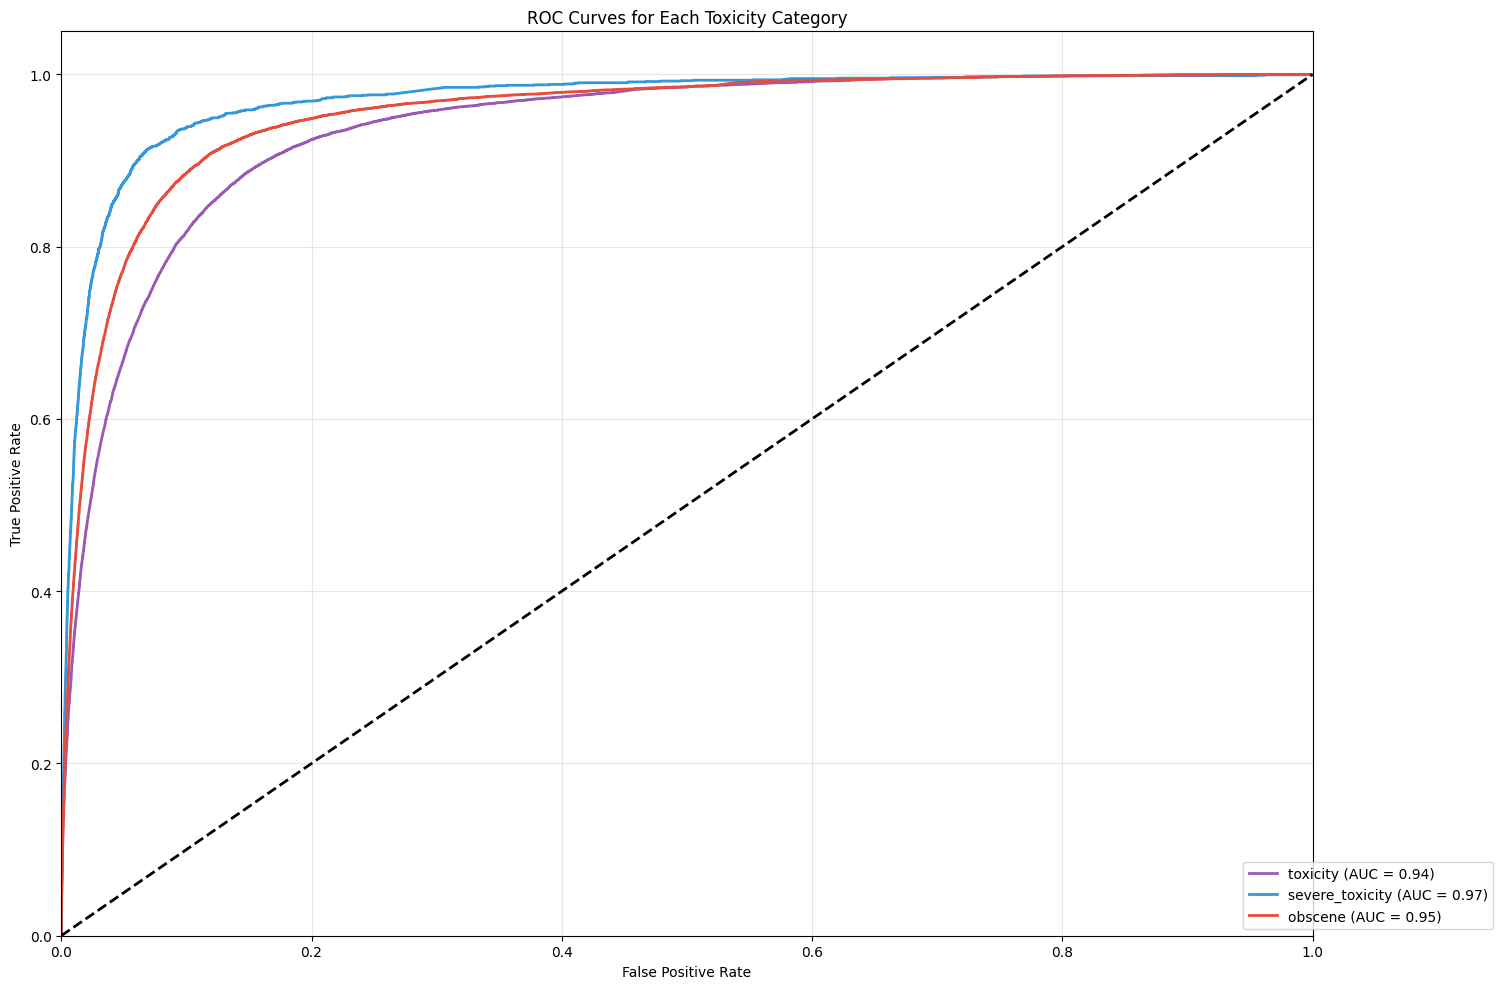

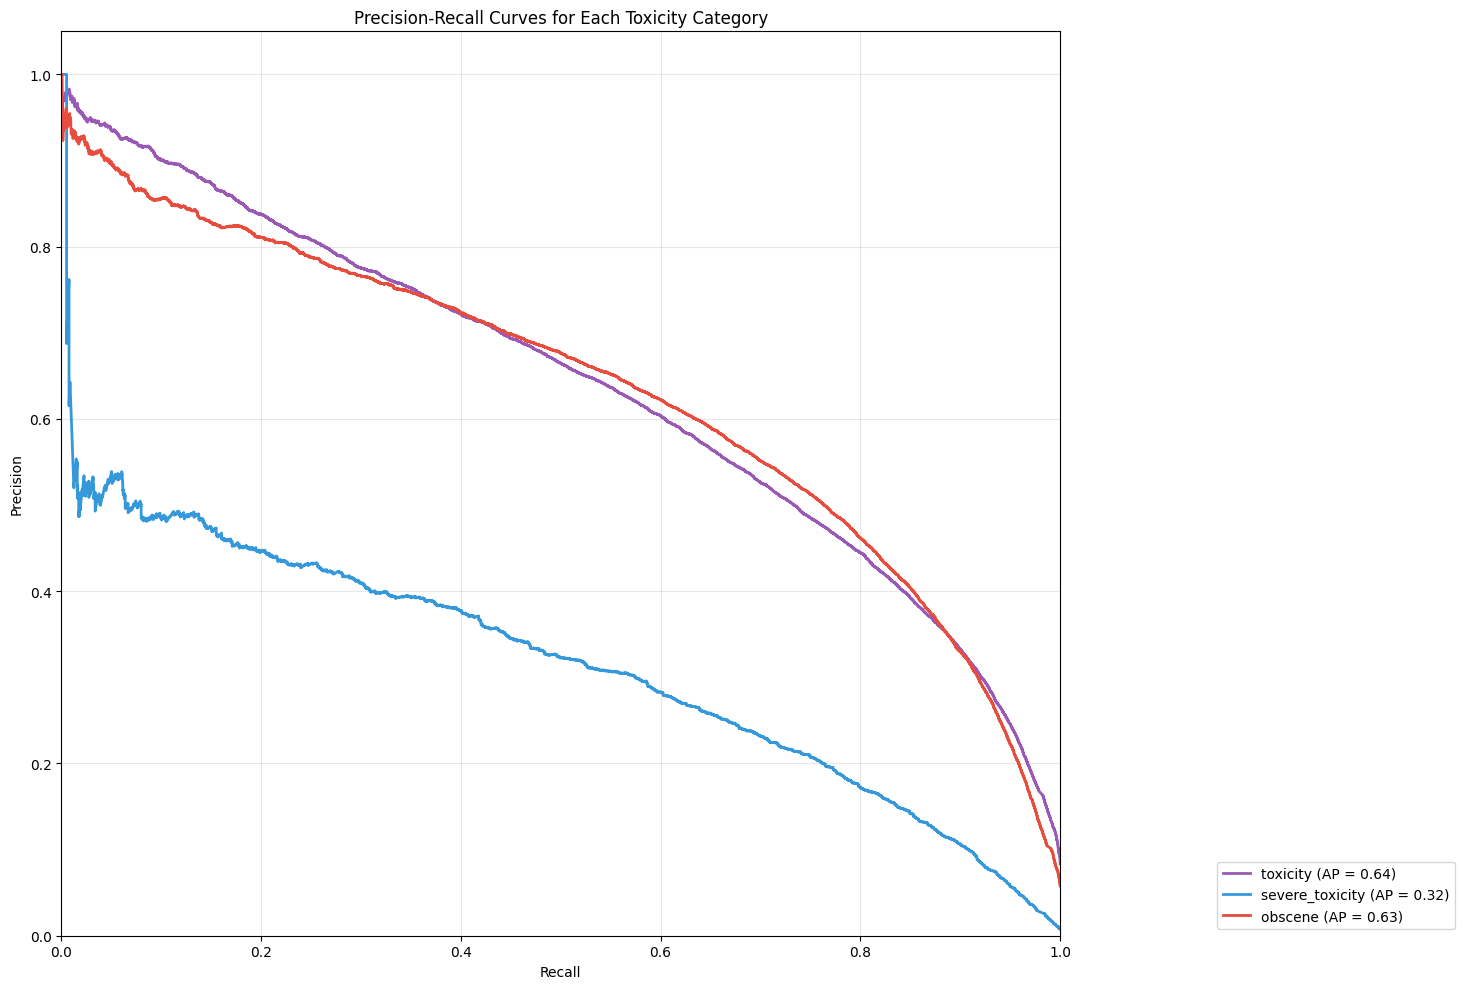

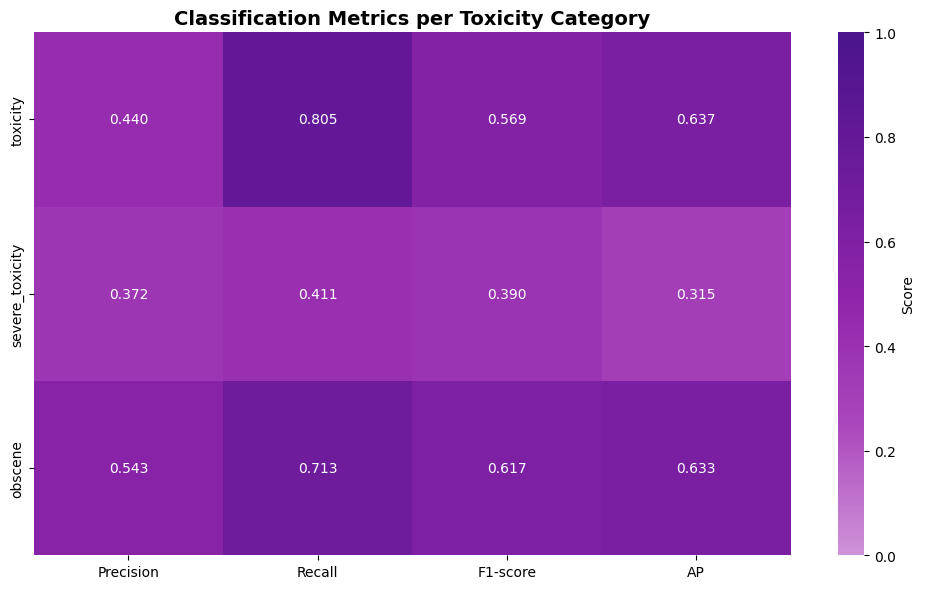

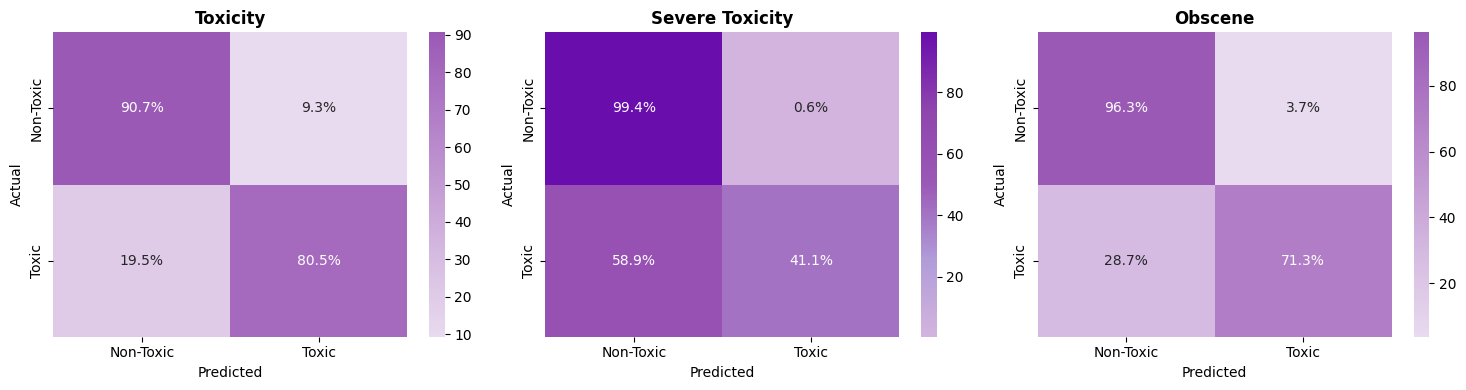

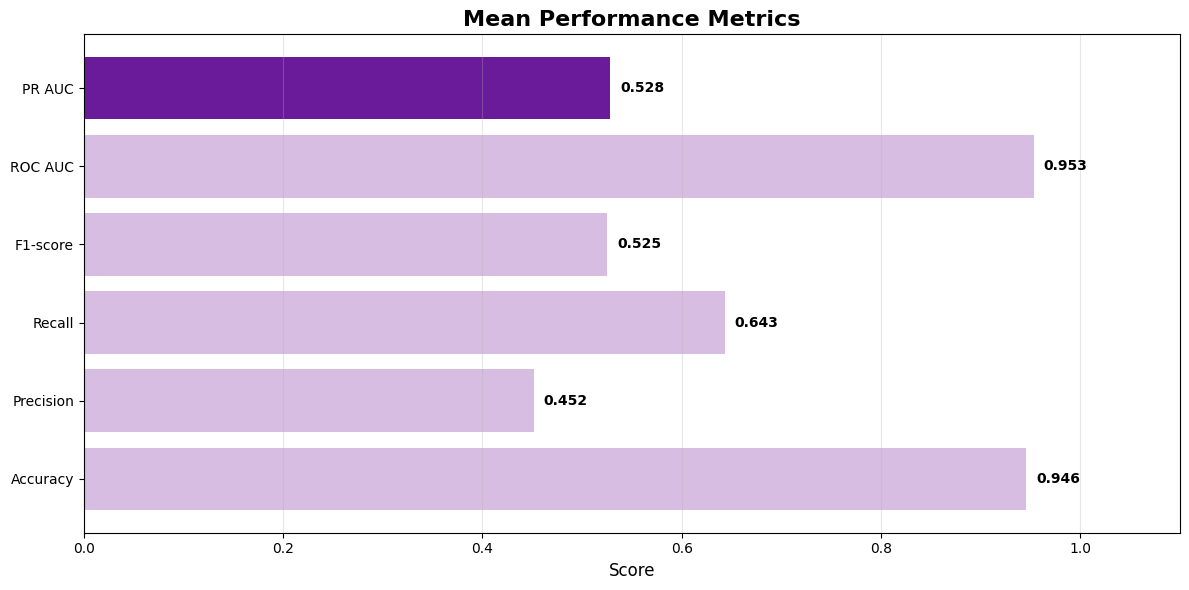


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.440
Recall: 0.805
F1-score: 0.569
Accuracy: 0.898
ROC AUC: 0.937
Average Precision: 0.637

Category: severe_toxicity
Precision: 0.372
Recall: 0.411
F1-score: 0.390
Accuracy: 0.990
ROC AUC: 0.970
Average Precision: 0.315

Category: obscene
Precision: 0.543
Recall: 0.713
F1-score: 0.617
Accuracy: 0.949
ROC AUC: 0.953
Average Precision: 0.633

Mean Metrics Across All Toxicity Categories:
--------------------------------------------------
mean_roc_auc: 0.953
mean_average_precision: 0.528
mean_precision: 0.452
mean_recall: 0.643
mean_f1_score: 0.525
mean_accuracy: 0.946
macro_avg:
  precision: 0.452
  recall: 0.643
  f1_score: 0.525
weighted_avg:
  precision: 0.476
  recall: 0.748
  f1_score: 0.578
total_support:
  negative: 737284.000
  positive: 38573.000


In [50]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

# Wrap in OneVsRestClassifier for multi-label classification
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_undersampling = evaluate_model(model=multilabel_classifier, test_set=test_set)


## Baseline with Backtranslated Dataset

In [63]:
# Load the dataset
df = pd.read_csv("../../data/merged_data/backtranslated_dataset.csv")

# Basic cleaning
df['comment_text'] = df['comment_text'].fillna('')

# Define toxic categories (target variables)
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']

print(f"Data loaded with shape: {df.shape}")
print(f"Target categories: {toxic_categories}")

# Create feature matrix (X) and target matrix (y)
X_train = df['comment_text']  # Using the raw text as features
y_train = df[toxic_categories].values  # Multi-label target matrix

df_test = pd.read_csv("../../data/merged_data/test_merged.csv")

X_test = df_test['comment_text']
y_test = df_test[toxic_categories].values

X_train_processed = X_train.apply(preprocess_text)
X_test_processed = X_test.apply(preprocess_text)


# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=40000,  
    min_df=3,            # Minimum document frequency
    max_df=0.9,          # Maximum document frequency
    ngram_range=(1, 4),  # Include unigrams, bigrams, and trigrams
    stop_words='english'
)


# Transform the text data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")
print(f"Target shape: {y_train.shape}")

Data loaded with shape: (535143, 33)
Target categories: ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_5360/1580093286.py:17: DtypeWarning: Columns (3,4,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("../../data/merged_data/test_merged.csv")


Training set shape: (535143, 40000)
Testing set shape: (258619, 40000)
Target shape: (535143, 7)


Evaluating the model...


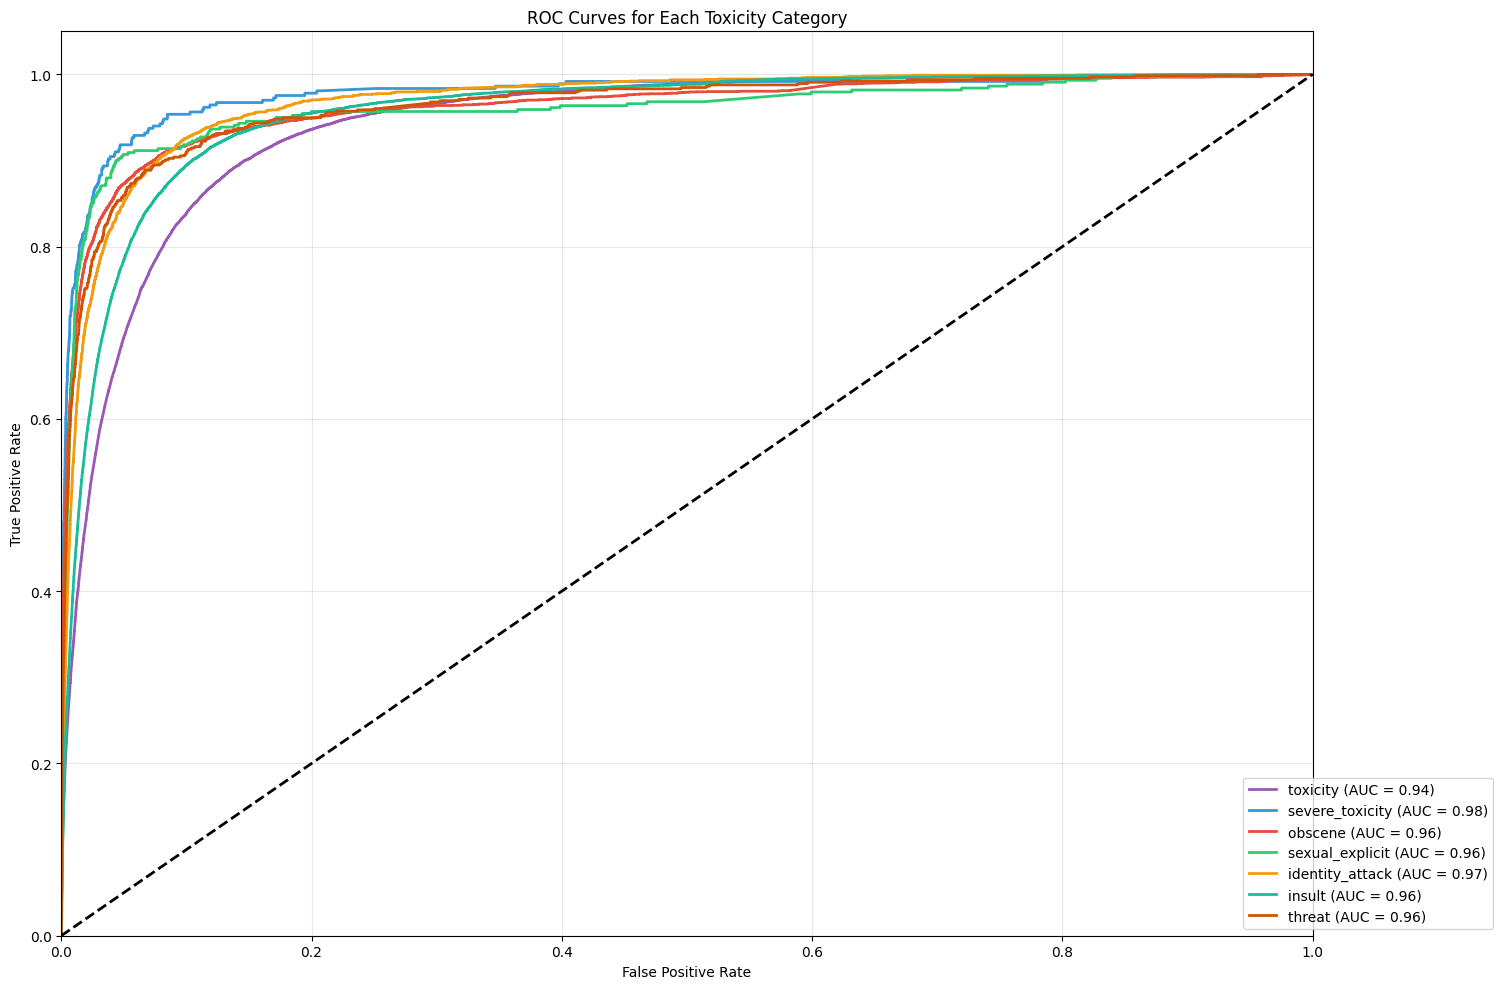

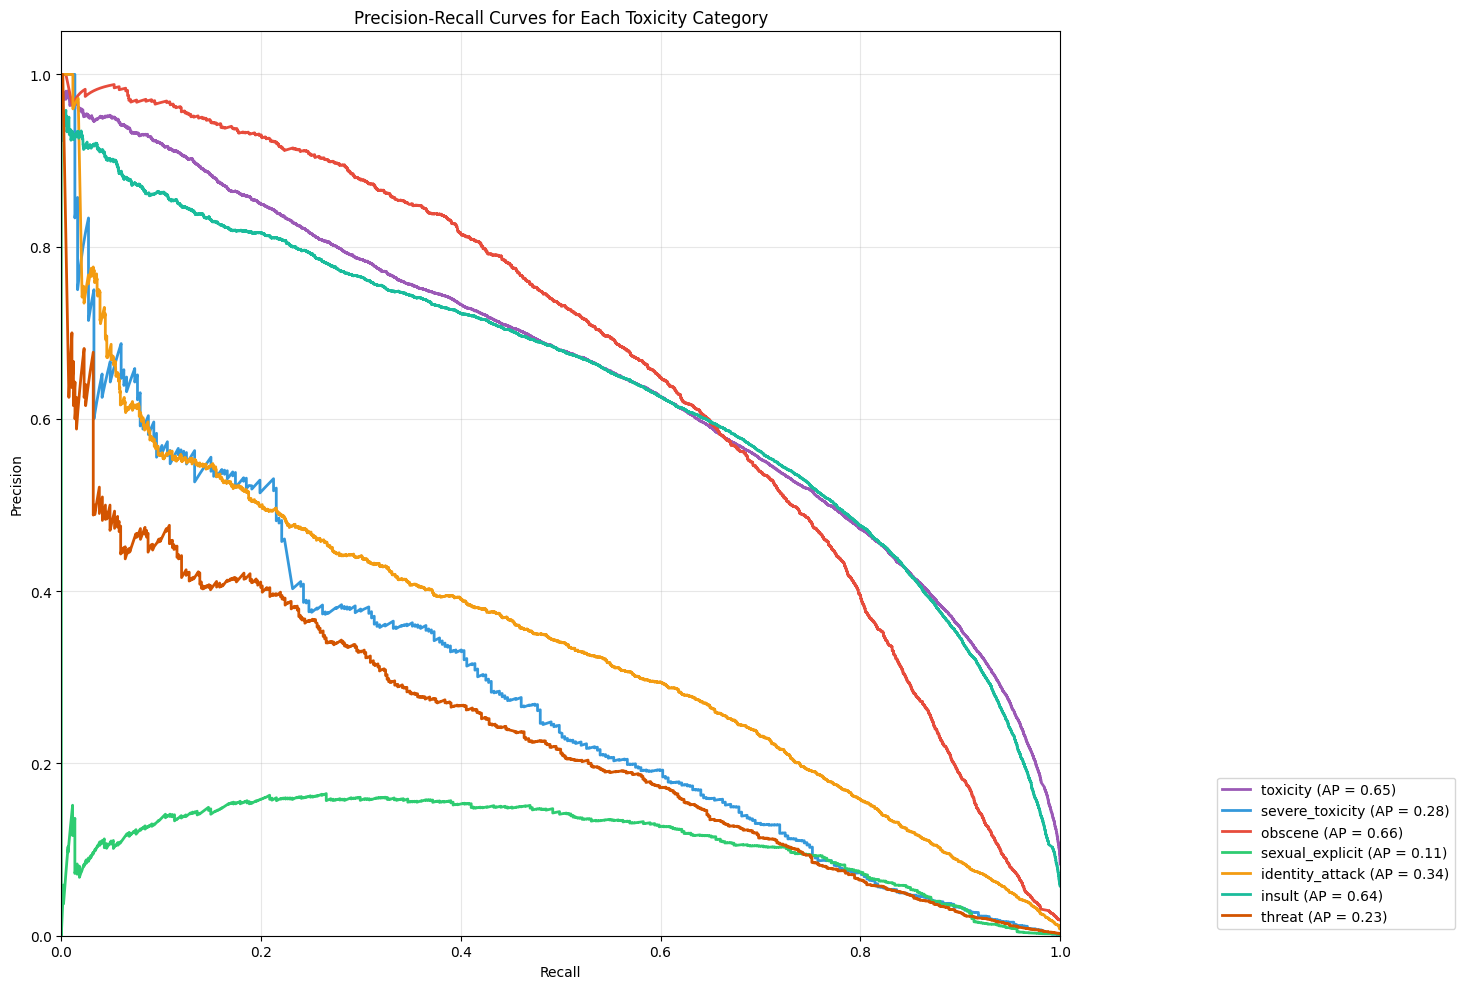

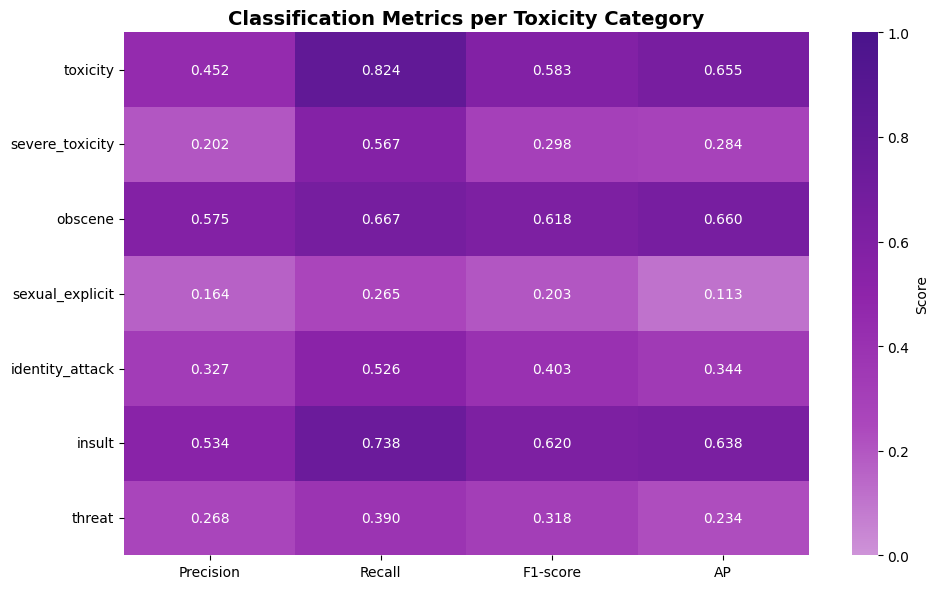

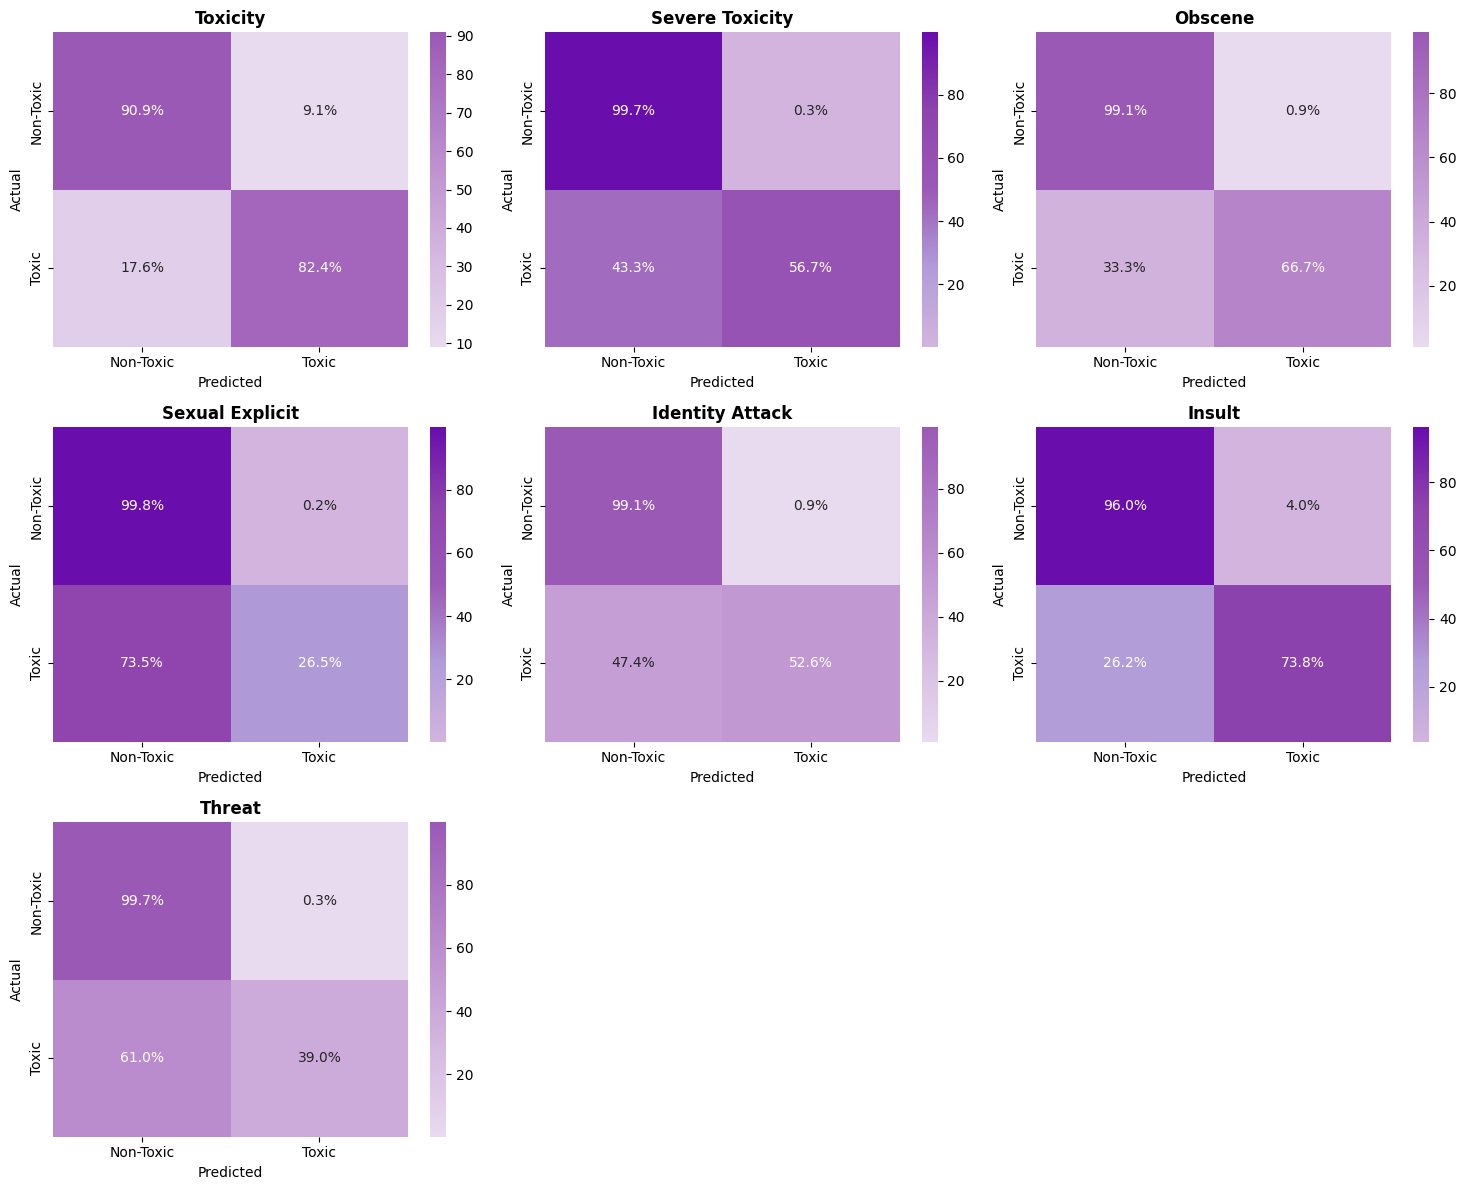

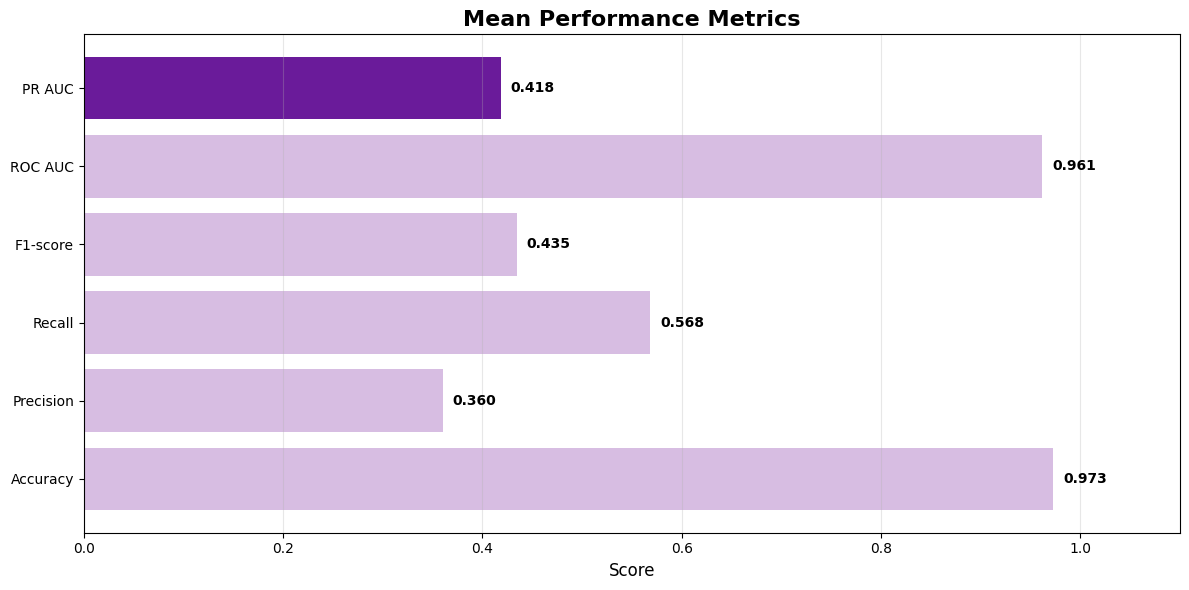


Detailed Classification Report:
--------------------------------------------------

Category: toxicity
Precision: 0.452
Recall: 0.824
F1-score: 0.583
Accuracy: 0.902
ROC AUC: 0.943
Average Precision: 0.655

Category: severe_toxicity
Precision: 0.202
Recall: 0.567
F1-score: 0.298
Accuracy: 0.996
ROC AUC: 0.977
Average Precision: 0.284

Category: obscene
Precision: 0.575
Recall: 0.667
F1-score: 0.618
Accuracy: 0.985
ROC AUC: 0.962
Average Precision: 0.660

Category: sexual_explicit
Precision: 0.164
Recall: 0.265
F1-score: 0.203
Accuracy: 0.996
ROC AUC: 0.960
Average Precision: 0.113

Category: identity_attack
Precision: 0.327
Recall: 0.526
F1-score: 0.403
Accuracy: 0.988
ROC AUC: 0.968
Average Precision: 0.344

Category: insult
Precision: 0.534
Recall: 0.738
F1-score: 0.620
Accuracy: 0.948
ROC AUC: 0.956
Average Precision: 0.638

Category: threat
Precision: 0.268
Recall: 0.390
F1-score: 0.318
Accuracy: 0.996
ROC AUC: 0.963
Average Precision: 0.234

Mean Metrics Across All Toxicity Categ

In [46]:
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

# Wrap in OneVsRestClassifier for multi-label classification
multilabel_classifier = OneVsRestClassifier(model)

# Fit the model with binary labels
multilabel_classifier.fit(X_train_tfidf, y_train_binary)

# Evaluate the model
print("Evaluating the model...")
evaluation_results_undersampling = evaluate_model(model=multilabel_classifier, test_set=test_set)


In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from tqdm import tqdm
import matplotlib.pyplot as plt

def evaluate_stratified_by_categories(model, vectorizer, original_df, toxic_categories, samples_per_class=1000, n_iterations=10, plot_pr_curve=True):
    """
    Stratified evaluation of the model multiple times on test sets sampled
    stratified by all toxic categories except 'toxicity'.

    Parameters:
    - model: trained multilabel classifier
    - vectorizer: fitted text vectorizer
    - original_df: DataFrame containing comment_text and labels
    - toxic_categories: list of category column names (including 'toxicity')
    - samples_per_class: number of samples per unique category combination per iteration
    - n_iterations: how many stratified samples to evaluate
    - plot_pr_curve: whether to plot Precision-Recall curves per category

    Returns:
    - results: dict with per-category metrics aggregated over iterations
    """

    stratify_cols = [cat for cat in toxic_categories if cat != 'toxicity']

    results = {category: {'auc': [], 'f1': []} for category in toxic_categories}
    pr_curves = {category: {'precision': [], 'recall': []} for category in toxic_categories}

    original_df = original_df.dropna(subset=['comment_text'])

    for i in tqdm(range(n_iterations), desc="Evaluating stratified test sets"):
        try:
            test_set = pd.DataFrame()

            # Get all unique combinations of stratify columns in the dataset
            unique_combinations = original_df[stratify_cols].drop_duplicates()

            # For each unique combination, sample samples_per_class rows
            for _, comb in unique_combinations.iterrows():
                mask = np.ones(len(original_df), dtype=bool)
                for col in stratify_cols:
                    mask &= (original_df[col] >= 0.5) if comb[col] >= 0.5 else (original_df[col] < 0.5)

                subset = original_df[mask]

                if len(subset) > 0:
                    sampled = subset.sample(n=min(samples_per_class, len(subset)), random_state=i)
                    test_set = pd.concat([test_set, sampled])

            if test_set.empty:
                print(f"Iteration {i} skipped, no samples for stratification.")
                continue

            # Prepare data
            X_test = vectorizer.transform(test_set['comment_text'].astype(str))
            y_test = (test_set[toxic_categories] >= 0.5).astype(int).values  # Binary labels thresholded at 0.5

            # Get predictions
            if hasattr(model, 'predict_proba'):
                y_pred = model.predict_proba(X_test)
                if isinstance(y_pred, list):
                    y_pred = np.array(y_pred).T
                elif len(y_pred.shape) == 2 and y_pred.shape[1] == 2:
                    y_pred = y_pred[:, 1].reshape(-1, 1)
            else:
                y_pred = model.decision_function(X_test)
                if len(y_pred.shape) == 1:
                    y_pred = y_pred.reshape(-1, 1)

            # Calculate metrics per category
            for j, category in enumerate(toxic_categories):
                try:
                    category_pred = y_pred[:, j] if len(y_pred.shape) > 1 else y_pred
                    category_true = y_test[:, j]

                    if len(np.unique(category_true)) < 2:
                        # Skip if only one class present
                        # print(f"Skipping AUC for {category} - only one class present.")
                        continue

                    auc_score = roc_auc_score(category_true, category_pred)
                    binary_pred = (category_pred > 0.3).astype(int)
                    f1 = f1_score(category_true, binary_pred)

                    precision, recall, _ = precision_recall_curve(category_true, category_pred)

                    results[category]['auc'].append(auc_score)
                    results[category]['f1'].append(f1)
                    pr_curves[category]['precision'].append(precision)
                    pr_curves[category]['recall'].append(recall)

                except Exception as e:
                    print(f"Error calculating metrics for {category}: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error in iteration {i}: {str(e)}")
            continue

    # Print aggregated statistics
    for category in toxic_categories:
        print(f"\nResults for {category}:")
        for metric in ['auc', 'f1']:
            values = results[category][metric]
            if values:
                mean = np.mean(values)
                std = np.std(values)
                ci_95 = 1.96 * std / np.sqrt(len(values))
                print(f"{metric.upper()}: Mean={mean:.4f}, Std={std:.4f}, 95% CI=({mean - ci_95:.4f}, {mean + ci_95:.4f})")
            else:
                print(f"{metric.upper()}: No valid results.")

    # Plot PR curves aggregated over all iterations per category
    if plot_pr_curve:
        for category in toxic_categories:
            plt.figure(figsize=(8, 6))
            for precision, recall in zip(pr_curves[category]['precision'], pr_curves[category]['recall']):
                plt.plot(recall, precision, alpha=0.3)
            plt.title(f'Precision-Recall Curve for {category}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.grid()
            plt.show()

    return results


/var/folders/xy/xqxsj6796gl11wpqz6hp11sr0000gn/T/ipykernel_5360/4285802666.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  original_df = pd.read_csv('../../data/merged_data/merged_dataset.csv')
Evaluating on random test sets: 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]



Results for toxicity:
AUC:
Mean: 0.9504
Std: 0.0049
95% CI: [0.9474, 0.9534]
F1:
Mean: 0.6485
Std: 0.0205
95% CI: [0.6358, 0.6612]

Results for severe_toxicity:
AUC:
Mean: 0.9983
Std: 0.0043
95% CI: [0.9956, 1.0010]
F1:
Mean: 0.6644
Std: 0.1692
95% CI: [0.5595, 0.7693]

Results for obscene:
AUC:
Mean: 0.9731
Std: 0.0196
95% CI: [0.9609, 0.9852]
F1:
Mean: 0.6635
Std: 0.0664
95% CI: [0.6223, 0.7046]

Results for sexual_explicit:
AUC:
Mean: 0.9679
Std: 0.0334
95% CI: [0.9472, 0.9885]
F1:
Mean: 0.2631
Std: 0.0847
95% CI: [0.2106, 0.3156]

Results for identity_attack:
AUC:
Mean: 0.9721
Std: 0.0109
95% CI: [0.9653, 0.9788]
F1:
Mean: 0.4262
Std: 0.0485
95% CI: [0.3961, 0.4562]

Results for insult:
AUC:
Mean: 0.9586
Std: 0.0048
95% CI: [0.9557, 0.9616]
F1:
Mean: 0.6593
Std: 0.0260
95% CI: [0.6432, 0.6754]

Results for threat:
AUC:
Mean: 0.9477
Std: 0.0358
95% CI: [0.9255, 0.9698]
F1:
Mean: 0.3285
Std: 0.1003
95% CI: [0.2664, 0.3907]


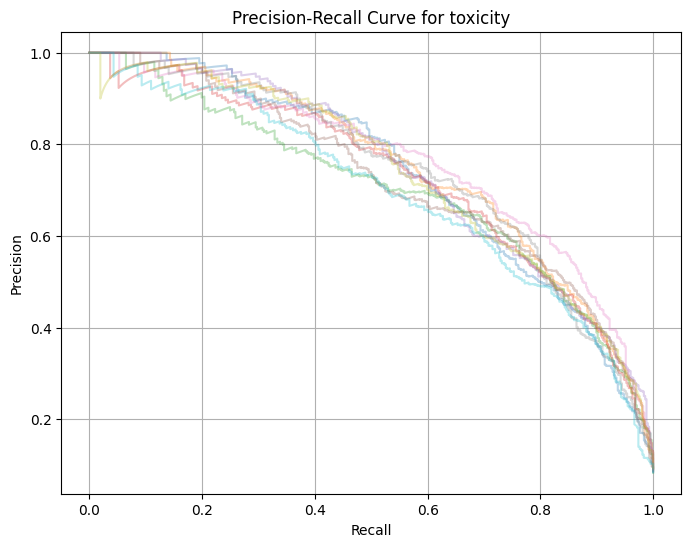

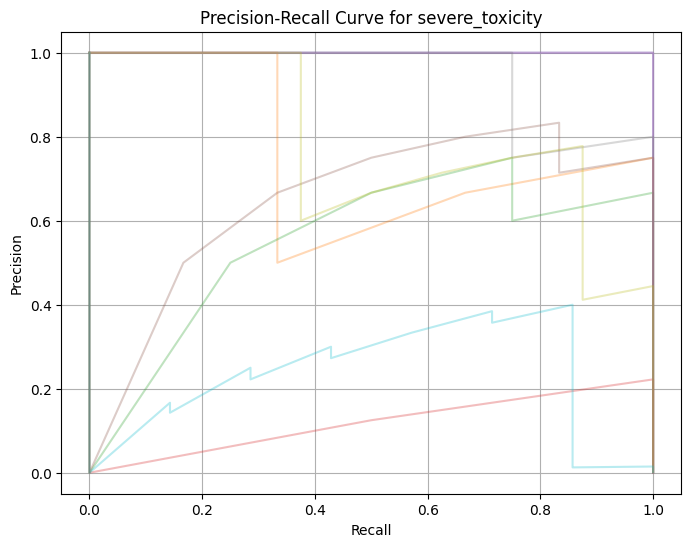

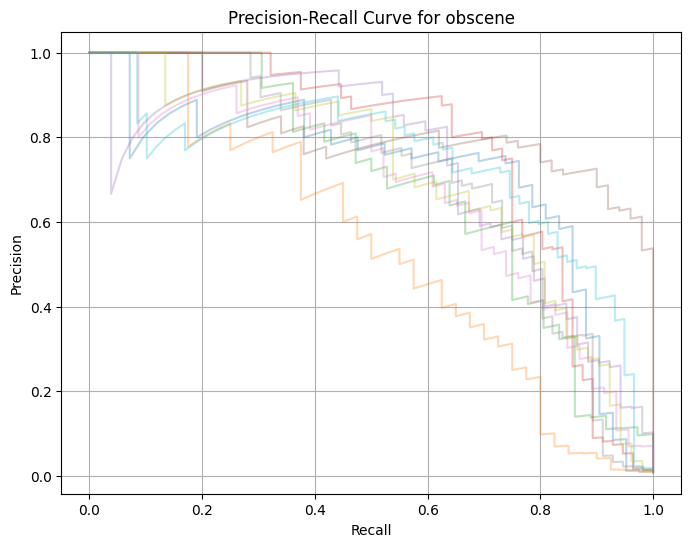

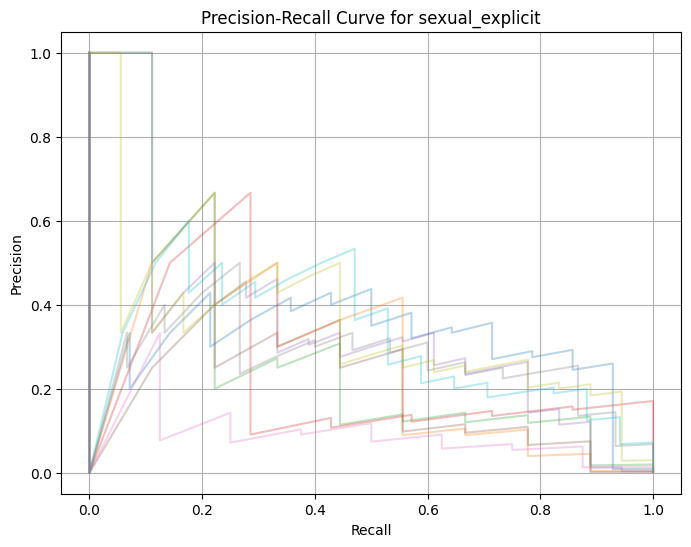

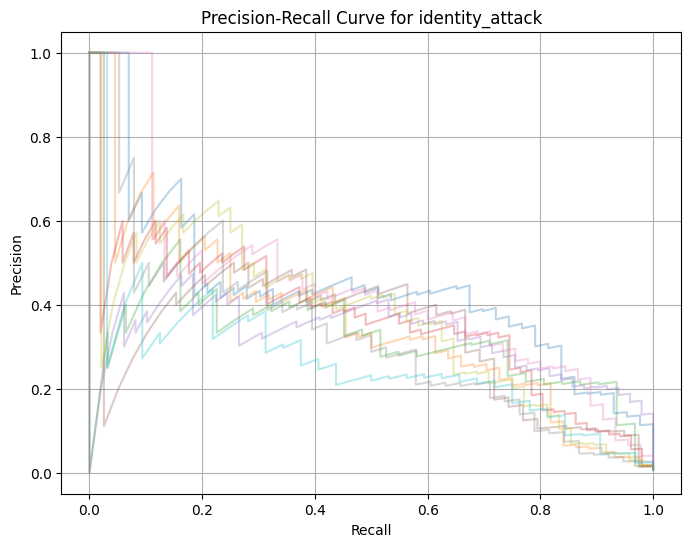

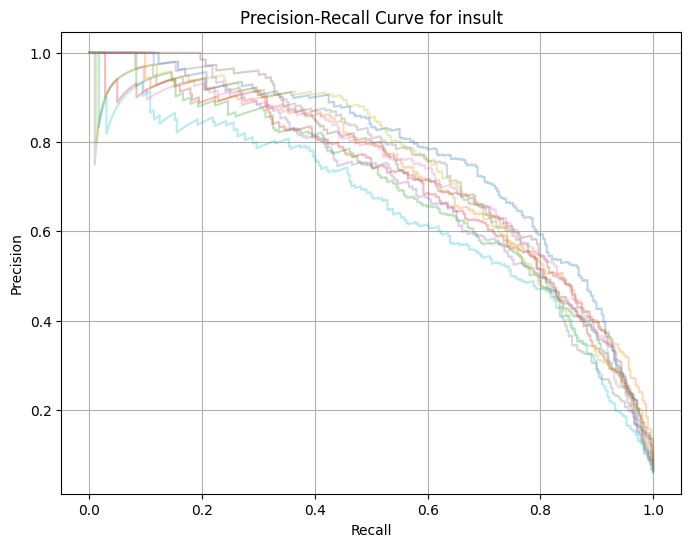

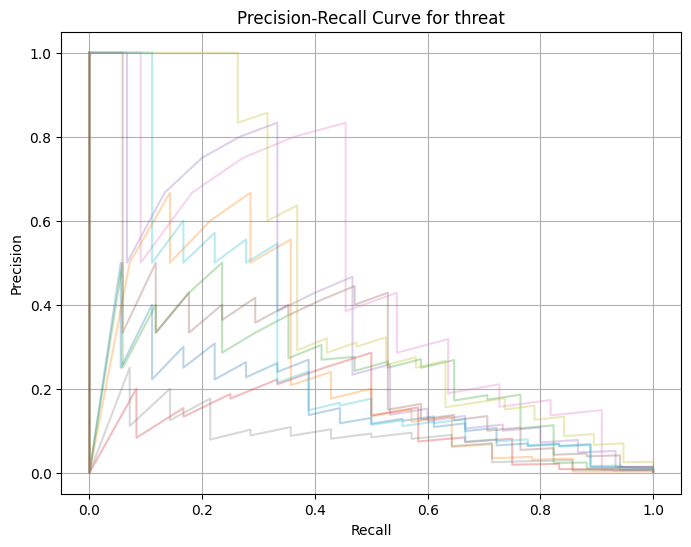

In [43]:
# Load dataset
original_df = pd.read_csv('../../data/merged_data/merged_dataset.csv')

# Define your toxic categories
toxic_categories = ['toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat']

# Ensure vectorizer is fitted
if not hasattr(tfidf_vectorizer, 'vocabulary_'):
    train_texts = original_df['comment_text'].dropna().astype(str)
    tfidf_vectorizer.fit(train_texts)

# Run evaluation
results = evaluate_multiple_test_sets(
    model=multilabel_classifier,
    vectorizer=tfidf_vectorizer,
    original_df=original_df,
    toxic_categories=toxic_categories,
    n_iterations=10,
    test_size=5000,
    plot_pr_curve=True
)

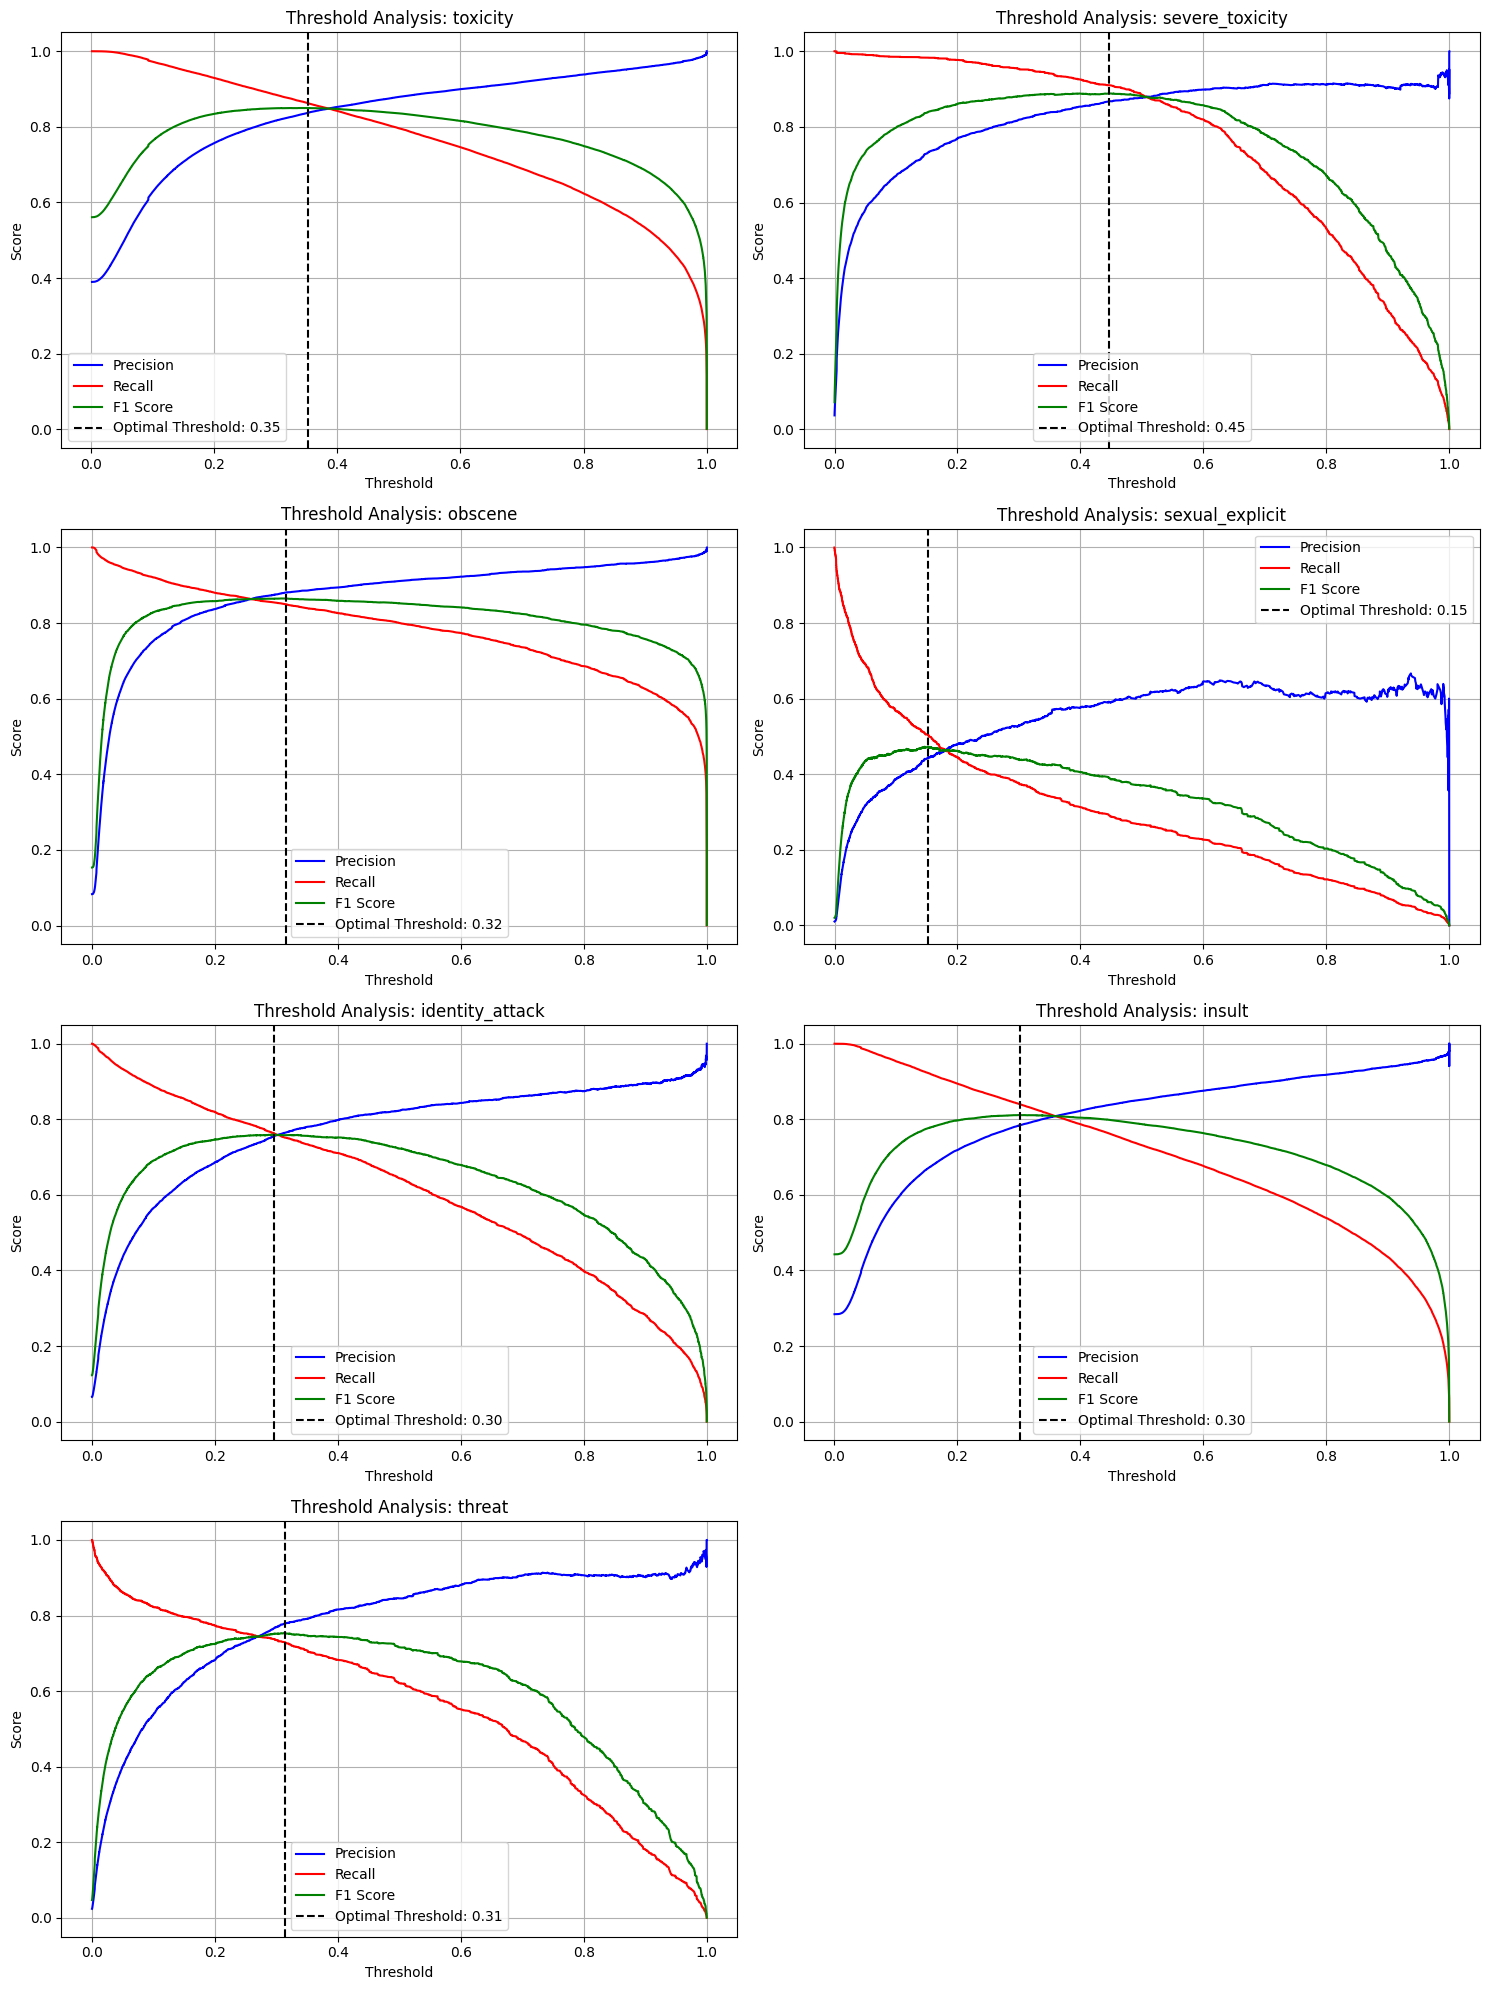


Optimal Thresholds and Metrics:
--------------------------------------------------------------------------------
Category             Threshold  Precision  Recall     F1 Score  
--------------------------------------------------------------------------------


ValueError: Invalid format specifier '.3f:<10' for object of type 'float'

In [ ]:
def perform_threshold_analysis(classifier, X_test, y_test, toxic_categories):
    """
    Perform threshold analysis for each category in the toxicity classification.
    """
    # Get probability predictions - this returns (n_samples, n_classes)
    y_pred_proba = classifier.predict_proba(X_test)
    
    # Initialize dictionaries to store results
    optimal_thresholds = {}
    optimal_metrics = {}
    
    # Create a figure with subplots
    n_rows = (len(toxic_categories) + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for idx, category in enumerate(toxic_categories):
        # Get probabilities for current category
        y_true_category = y_test[:, idx]
        y_pred_proba_category = y_pred_proba[:, idx]  # Changed this line
        
        # Calculate precision-recall curve
        precisions, recalls, thresholds = precision_recall_curve(y_true_category, y_pred_proba_category)
        
        # Calculate F1 scores for different thresholds
        f1_scores = []
        for threshold in thresholds:
            y_pred_binary = (y_pred_proba_category >= threshold).astype(int)
            f1 = f1_score(y_true_category, y_pred_binary)
            f1_scores.append(f1)
        
        # Find optimal threshold (maximum F1 score)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        # Store optimal threshold and metrics
        optimal_thresholds[category] = optimal_threshold
        optimal_metrics[category] = {
            'threshold': optimal_threshold,
            'precision': precisions[optimal_idx],
            'recall': recalls[optimal_idx],
            'f1_score': f1_scores[optimal_idx]
        }
        
        # Plot precision-recall curve and F1 scores
        ax = axes[idx]
        ax.plot(thresholds, precisions[:-1], label='Precision', color='blue')
        ax.plot(thresholds, recalls[:-1], label='Recall', color='red')
        ax.plot(thresholds, f1_scores, label='F1 Score', color='green')
        
        # Plot optimal threshold
        ax.axvline(x=optimal_threshold, color='black', linestyle='--', 
                  label=f'Optimal Threshold: {optimal_threshold:.2f}')
        
        ax.set_title(f'Threshold Analysis: {category}')
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(True)
    
    # Remove any empty subplots
    for idx in range(len(toxic_categories), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nOptimal Thresholds and Metrics:")
    print("-" * 80)
    print(f"{'Category':<20} {'Threshold':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}")
    print("-" * 80)
    
    for category in toxic_categories:
        metrics = optimal_metrics[category]
        print(f"{category:<20} "
              f"{metrics['threshold']:.2f} "
              f"{metrics['precision']:.2f} "
              f"{metrics['recall']:.2f} "
              f"{metrics['f1_score']:.2f}")
    
    return optimal_thresholds, optimal_metrics

def predict_with_optimal_thresholds(classifier, X, optimal_thresholds, toxic_categories):
    """
    Make predictions using optimal thresholds for each category.
    """
    # Get probability predictions
    y_pred_proba = classifier.predict_proba(X)
    
    # Initialize array for final predictions
    final_predictions = np.zeros((X.shape[0], len(toxic_categories)))
    
    # Apply optimal thresholds for each category
    for idx, category in enumerate(toxic_categories):
        threshold = optimal_thresholds[category]
        final_predictions[:, idx] = (y_pred_proba[:, idx] >= threshold).astype(int)
    
    return final_predictions

# Use the functions
optimal_thresholds, optimal_metrics = perform_threshold_analysis(
    classifier=multilabel_classifier,
    X_test=X_test_tfidf,
    y_test=y_test_binary,
    toxic_categories=toxic_categories
)


In [24]:
from sklearn.metrics import jaccard_score
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.multiclass import OneVsRestClassifier
# Prepare the test set
y_test_binary = (y_test >= 0.5).astype(int)  # Convert to binary
test_set = (X_test_tfidf, y_test_binary)

# Convert training labels to binary
y_train_binary = (y_train >= 0.5).astype(int)  # Convert to binary

# Create the model with best parameters
model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear',
    max_iter=1000,
    class_weight=None,
    random_state=42
)

ovr = OneVsRestClassifier(model)
ovr.fit(X_train_tfidf, y_train_binary)
Y_pred_ovr = ovr.predict(X_test_tfidf)
ovr_jaccard_score = jaccard_score(y_test_binary, Y_pred_ovr, average="samples")

chains = [ClassifierChain(model, order="random", random_state=i) for i in range(10)]
for chain in chains:
    chain.fit(X_train_tfidf, y_train_binary)

Y_pred_chains = np.array([chain.predict_proba(X_test_tfidf) for chain in chains])
chain_jaccard_scores = [
    jaccard_score(y_test_binary, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    y_test_binary, Y_pred_ensemble >= 0.5, average="samples"
)

/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sofiasartori/Desktop/Git/ai-auto-moderation-api/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_div

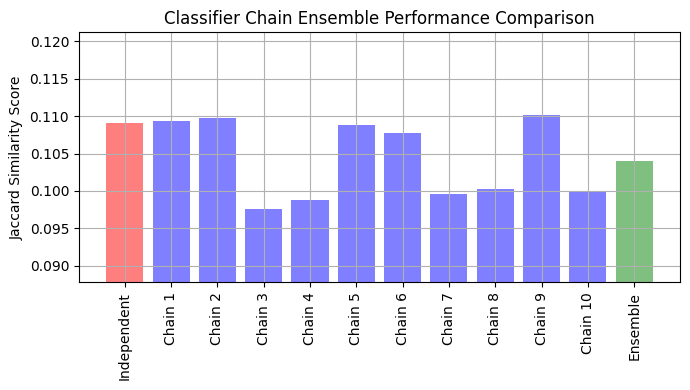

In [25]:
model_scores = [ovr_jaccard_score] + chain_jaccard_scores + [ensemble_jaccard_score]

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()